21 iterations were performed
Distances of clusters as compared to last generation:[0.0, 0.0, 0.0, 0.0, 0.0]
Runtime: 0:00:05.867820
kmeans centroids: [[ 89.78498077 177.08198547]
 [-20.72677803  47.7699852 ]
 [173.70606995 -25.57680511]
 [ 49.89459229 -69.2551651 ]
 [-45.54481506 -31.11758614]]
Runtime: 0:00:00.132001
sklearnkmeans centroids: [[-45.720825 -33.25469 ]
 [-21.425753  46.127117]
 [ 52.14777  -68.04193 ]
 [ 85.96934  173.40851 ]
 [174.54161  -25.316248]]


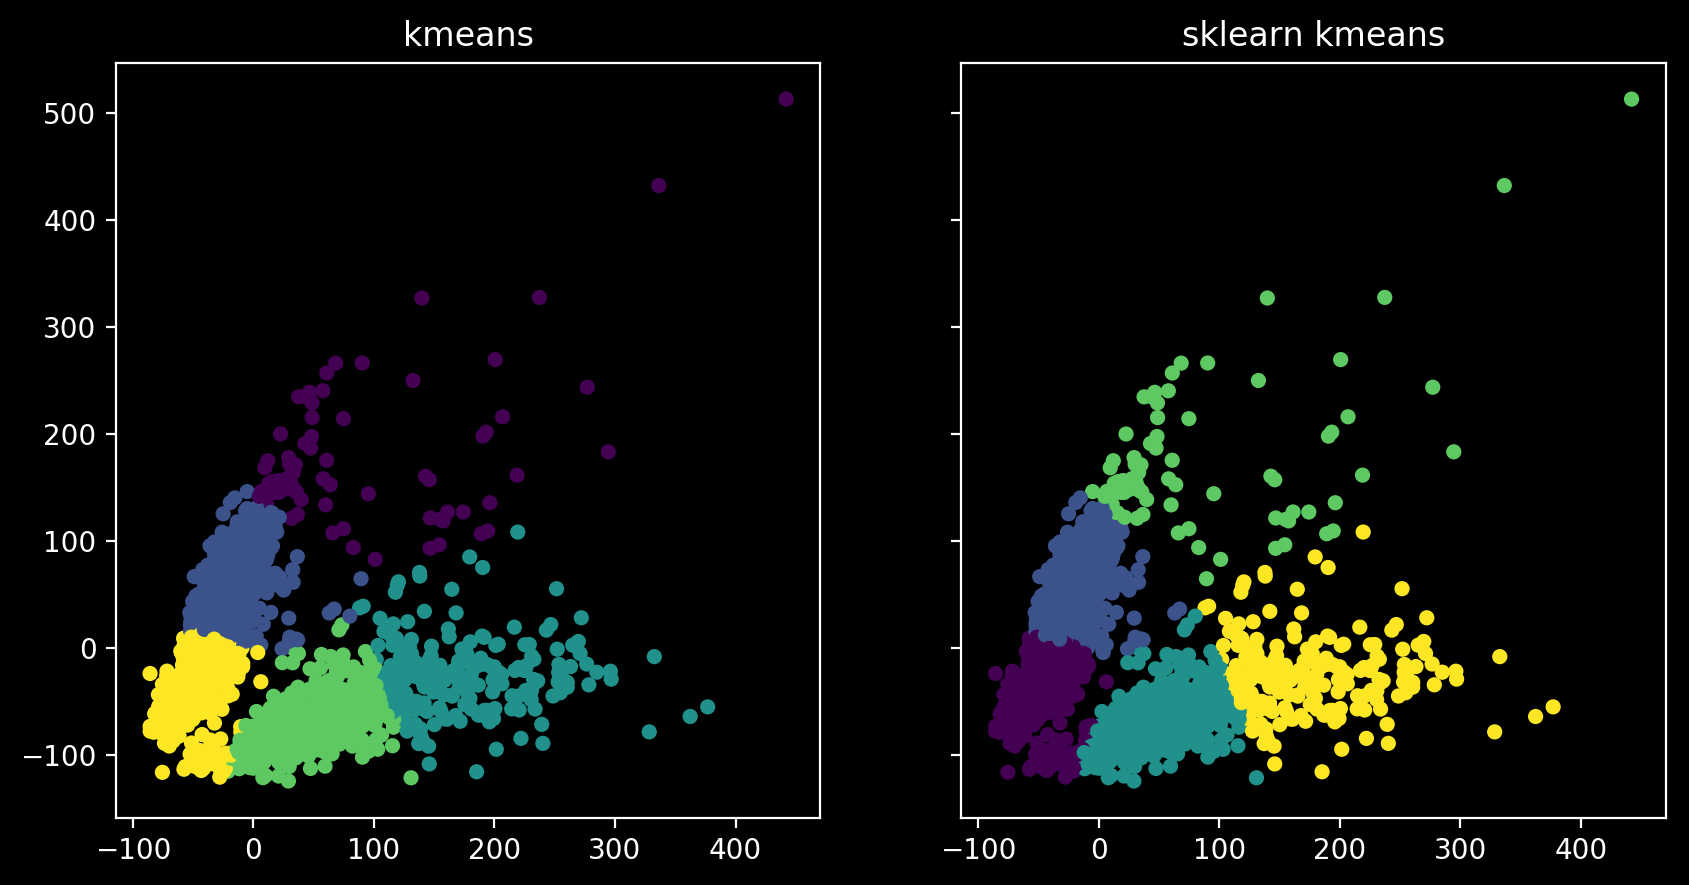

In [1]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t = 0
patients = 0
genes = 0
centroids_array = 0 
centroids_oldarray = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data))* np.random.random_sample((k, genes)) + np.amin(pca_data)

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i+1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # While loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
        
#Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    print("Distances of clusters as compared to last generation:" + str(distances))
        
    
                  
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("randnum")
        assign_centroids()
        empty_check()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1
        improv()

#kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # set threshold
    improv()

# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
#runtime_start()
#kmeans(5, 10)
#print(runtime_end())

#Execute threshold kmeans
runtime_start()
tkmeans(5)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)

In [2]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    print("Distances of clusters as compared to last generation:" + str(distances))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(2)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


KeyboardInterrupt: 

In [3]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    print("Distances of clusters as compared to last generation:" + str(distances))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


Empty cluster! Correcting centroids.


KeyboardInterrupt: 

Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.
22 iterations were performed
Distances of clusters as compared to last generation:[0.0, 0.0, 0.0876182180007162, 0.07860154050267942, 0.0]

kmeans:
runtime: 0:00:02.818831
centroids: 
 [-45.57 -32.82]
 [-21.17  46.72]
 [ 51.97 -68.15]
 [ 88.57 176.68]
 [174.54 -25.32]

sklearn kmeans:
runtime: 0:00:00.092000
centroids: 
 [-45.72 -33.25]
 [-21.43  46.13]
 [ 52.15 -68.04]
 [ 85.97 173.41]
 [174.54 -25.32]


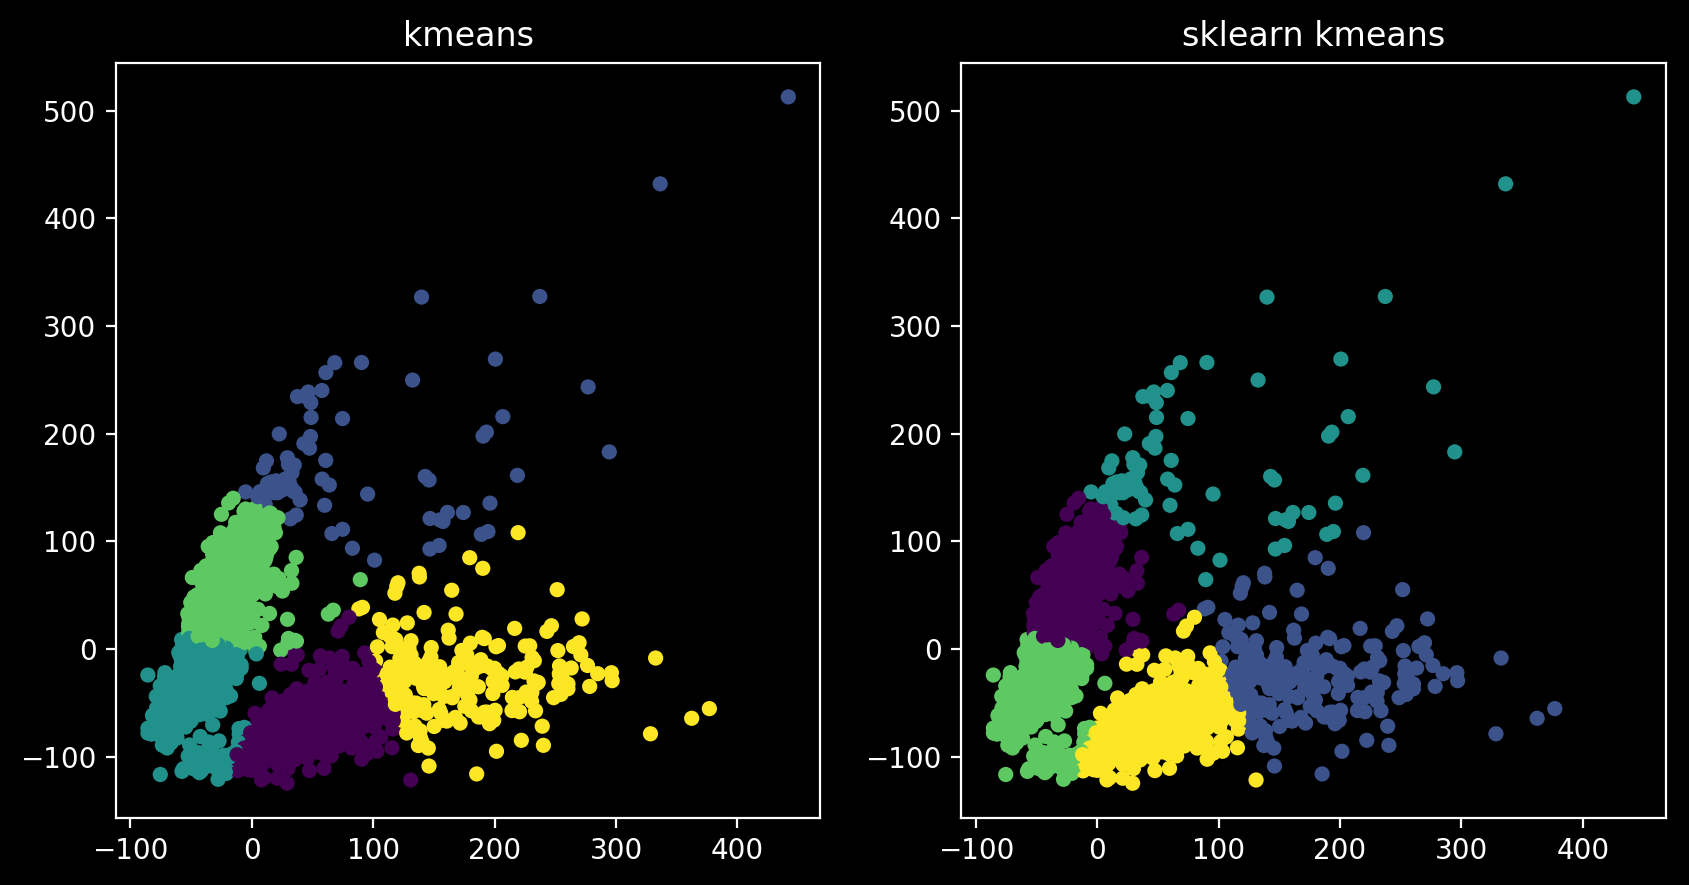

In [4]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    print("Distances of clusters as compared to last generation:" + str(distances))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


Empty cluster! Correcting centroids.
24 iterations were performed
Distances of clusters as compared to last generation: 
[0.08349723843018539, 0.0, 0.0, 0.08492106102722873, 0.0]

kmeans:
runtime: 0:00:03.092002
centroids: 
 [-45.51 -28.26]
 [-20.06  49.41]
 [ 42.84 -72.53]
 [ 94.79 177.74]
 [167.11 -28.12]

sklearn kmeans:
runtime: 0:00:00.105013
centroids: 
 [-45.72 -33.25]
 [-21.43  46.13]
 [ 52.15 -68.04]
 [ 85.97 173.41]
 [174.54 -25.32]


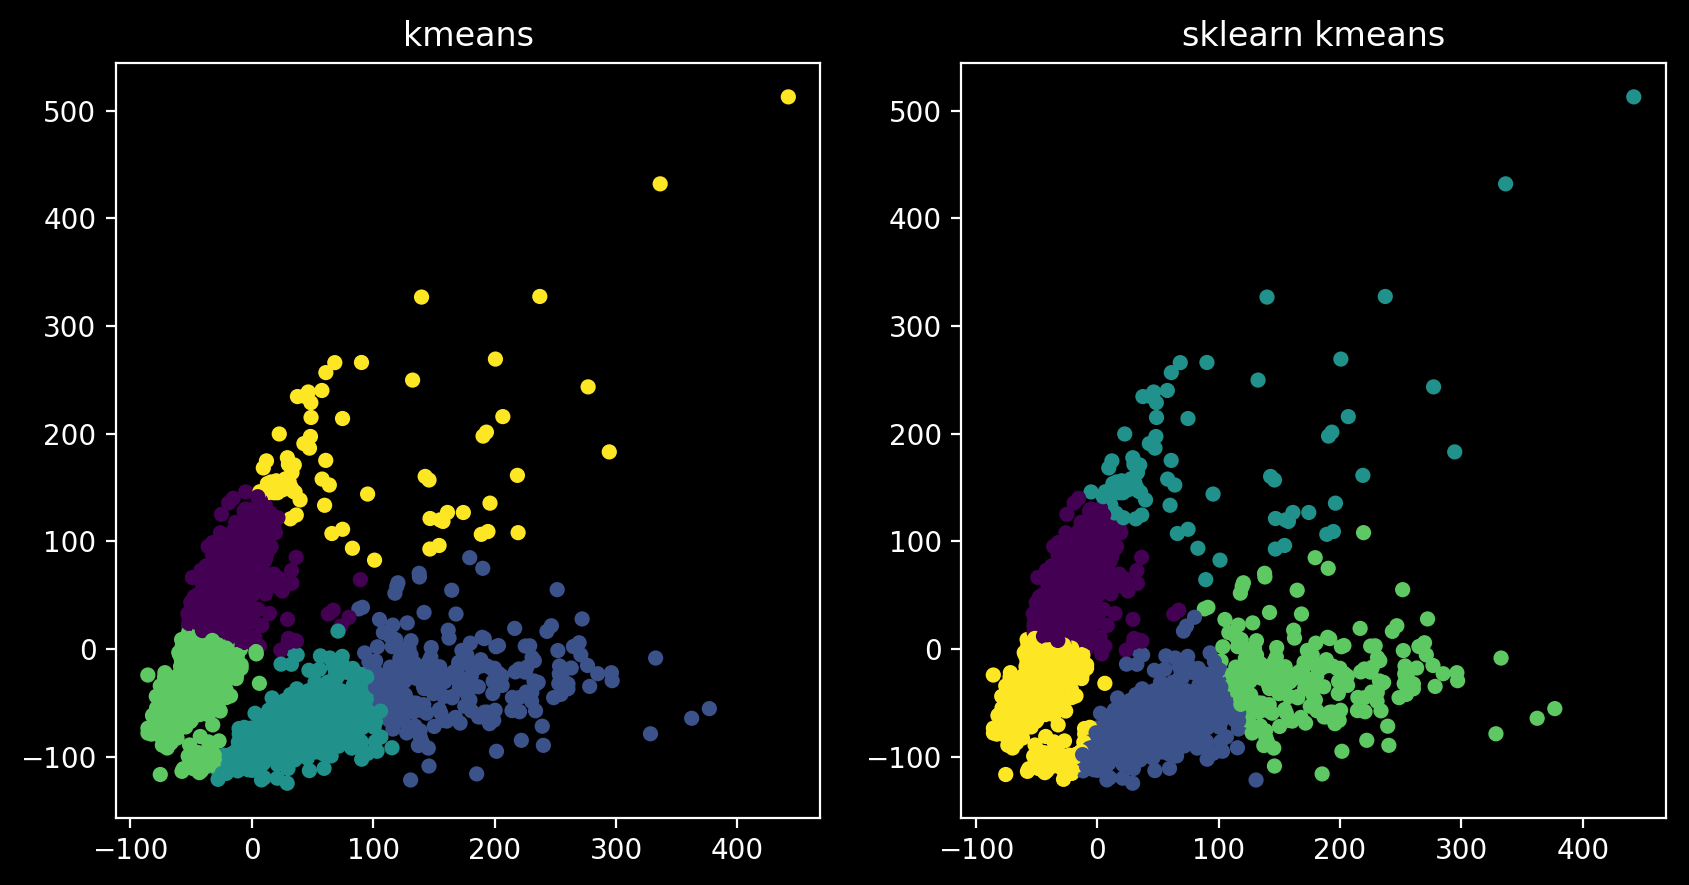

In [5]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    print("Distances of clusters as compared to last generation: \n" + str(distances))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


In [6]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(distances, precision=2, separator=' ')
    print("Distances of clusters as compared to last generation: \n" + str(distances))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.
48 iterations were performed


AttributeError: 'list' object has no attribute 'size'

In [7]:
distances


NameError: name 'distances' is not defined

In [8]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(distances, precision=2, separator=' ')
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


44 iterations were performed


AttributeError: 'list' object has no attribute 'size'

In [9]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string([distances], precision=2, separator=' ')
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


40 iterations were performed


AttributeError: 'list' object has no attribute 'size'

In [1]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string([distances], precision=2, separator=' ')
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


24 iterations were performed


AttributeError: 'list' object has no attribute 'size'

Empty cluster! Correcting centroids.
35 iterations were performed
Distances of clusters as compared to last generation: 
[0.   0.06 0.06 0.07 0.  ]

kmeans:
runtime: 0:00:04.026376
centroids: 
 [-35.3    3.05]
 [-25.86 -68.04]
 [-11.42  71.75]
 [133.88 -38.63]
 [142.03 199.53]

sklearn kmeans:
runtime: 0:00:00.099990
centroids: 
 [-45.72 -33.25]
 [-21.43  46.13]
 [ 52.15 -68.04]
 [ 85.97 173.41]
 [174.54 -25.32]


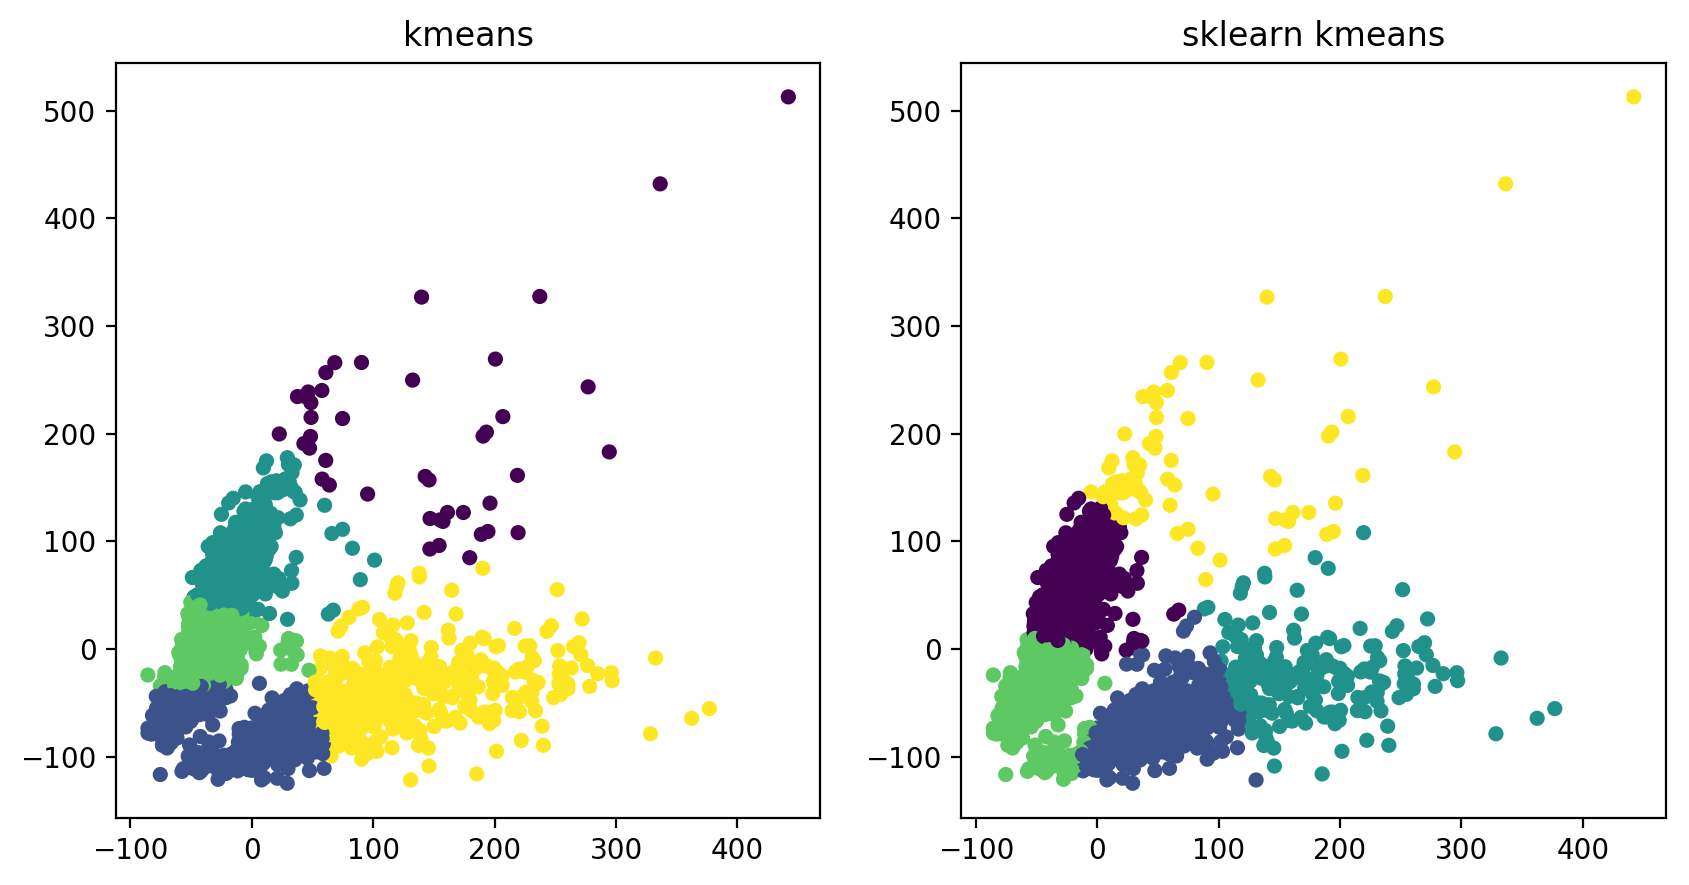

In [2]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), precision=2, separator=' ')
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


42 iterations were performed
Distances of clusters as compared to last generation: 
[0.07 0.00 0.06 0.00 0.06]

kmeans:
runtime: 0:00:04.621361
centroids: 
 [-35.3    3.05]
 [-25.86 -68.04]
 [-11.42  71.75]
 [133.88 -38.63]
 [142.03 199.53]

sklearn kmeans:
runtime: 0:00:00.088000
centroids: 
 [-45.39 -28.61]
 [-20.16  49.48]
 [ 45.64 -71.36]
 [ 94.79 177.74]
 [169.85 -26.89]


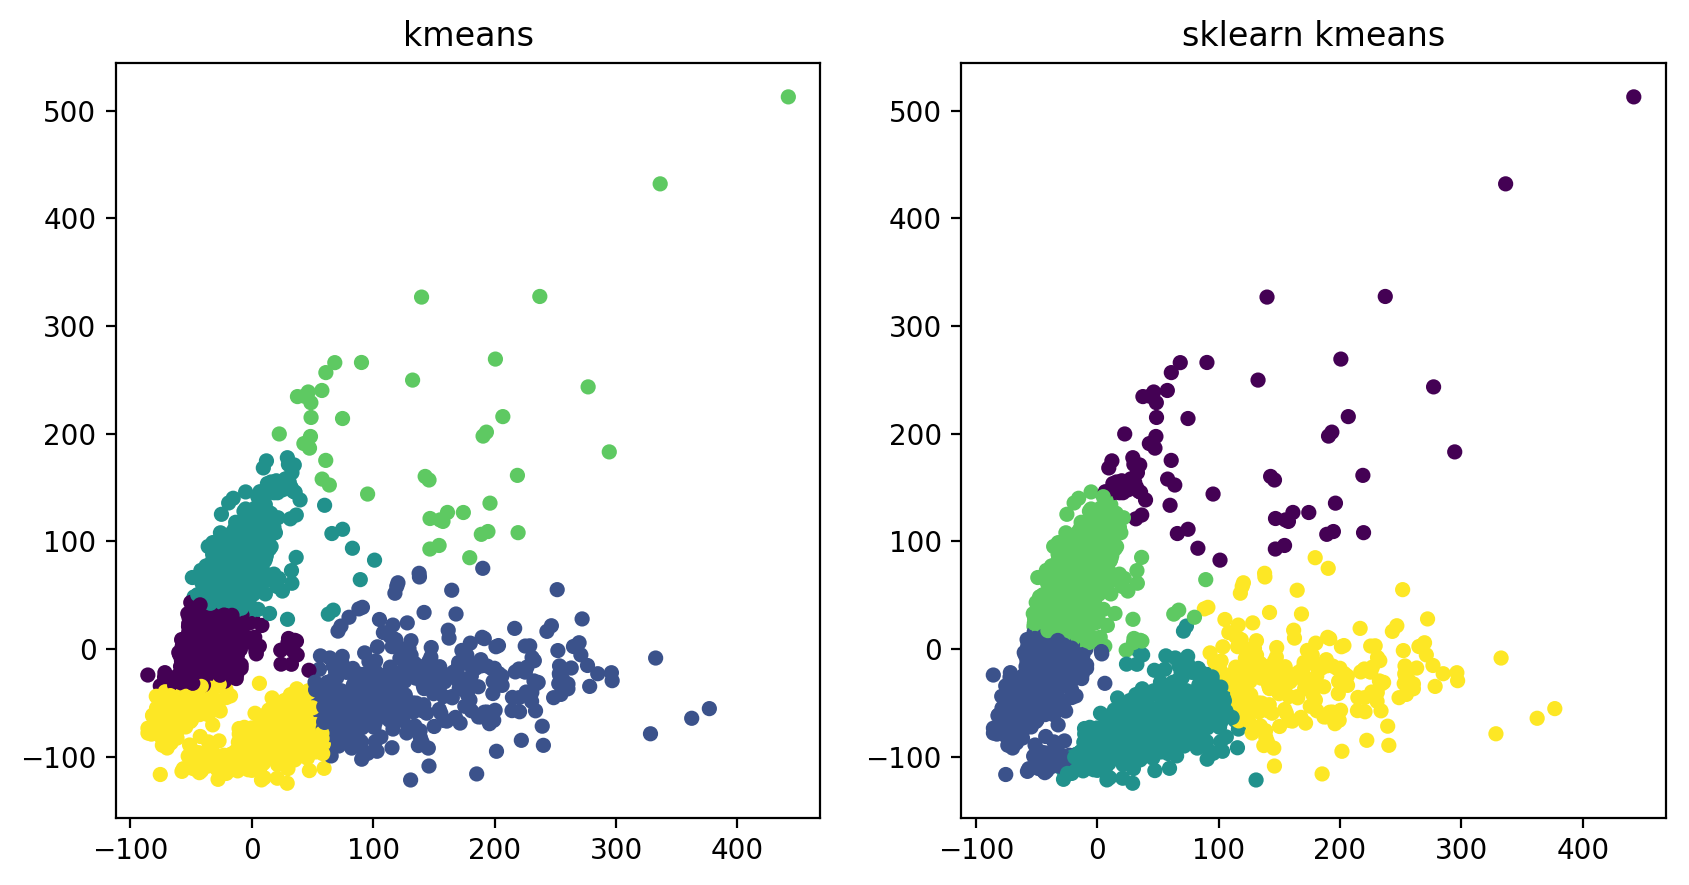

In [3]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), formatter={'float_kind':lambda x: "%.2f" % x}, separator=' ')
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


40 iterations were performed
Distances of clusters as compared to last generation: 
[0.00 0.00 0.04 0.00 0.04]

kmeans:
runtime: 0:00:04.711618
centroids: 
 [-45.72 -33.25]
 [-21.43 46.13]
 [52.15 -68.04]
 [85.97 173.41]
 [174.54 -25.32]

sklearn kmeans:
runtime: 0:00:00.123994
centroids: 
 [-45.71 -33.21]
 [-21.41 46.16]
 [52.15 -68.04]
 [85.97 173.41]
 [174.54 -25.32]


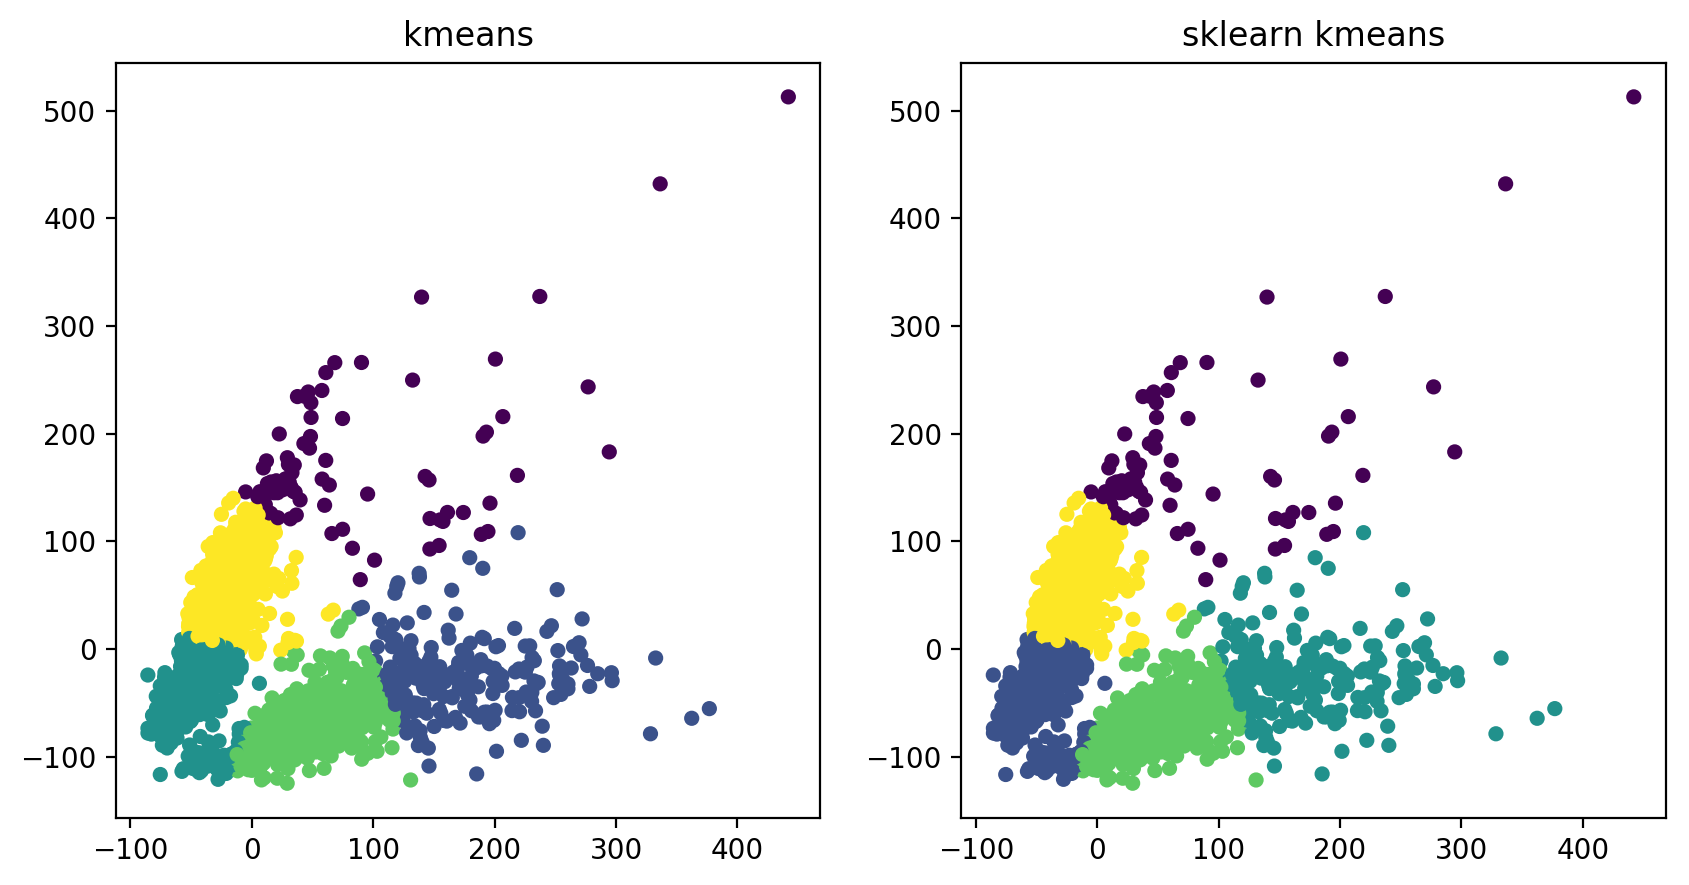

In [4]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), formatter={'float_kind':lambda x: "%.2f" % x}, separator=' ')
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], formatter={'float_kind':lambda x: "%.2f" % x}, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], formatter={'float_kind':lambda x: "%.2f" % x}, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


In [5]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), precision=2, separator=' ', supress = False)
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.
22 iterations were performed


TypeError: array2string() got unexpected keyword argument 'supress'

47 iterations were performed
Distances of clusters as compared to last generation: 
[0.07 0.06 0.   0.06 0.  ]

kmeans:
runtime: 0:00:05.400036
centroids: 
 [-35.3    3.05]
 [-25.86 -68.04]
 [-11.42  71.75]
 [133.88 -38.63]
 [142.03 199.53]

sklearn kmeans:
runtime: 0:00:00.108021
centroids: 
 [-45.76 -30.39]
 [-20.95  47.47]
 [ 46.34 -71.08]
 [ 85.97 173.41]
 [170.06 -26.32]


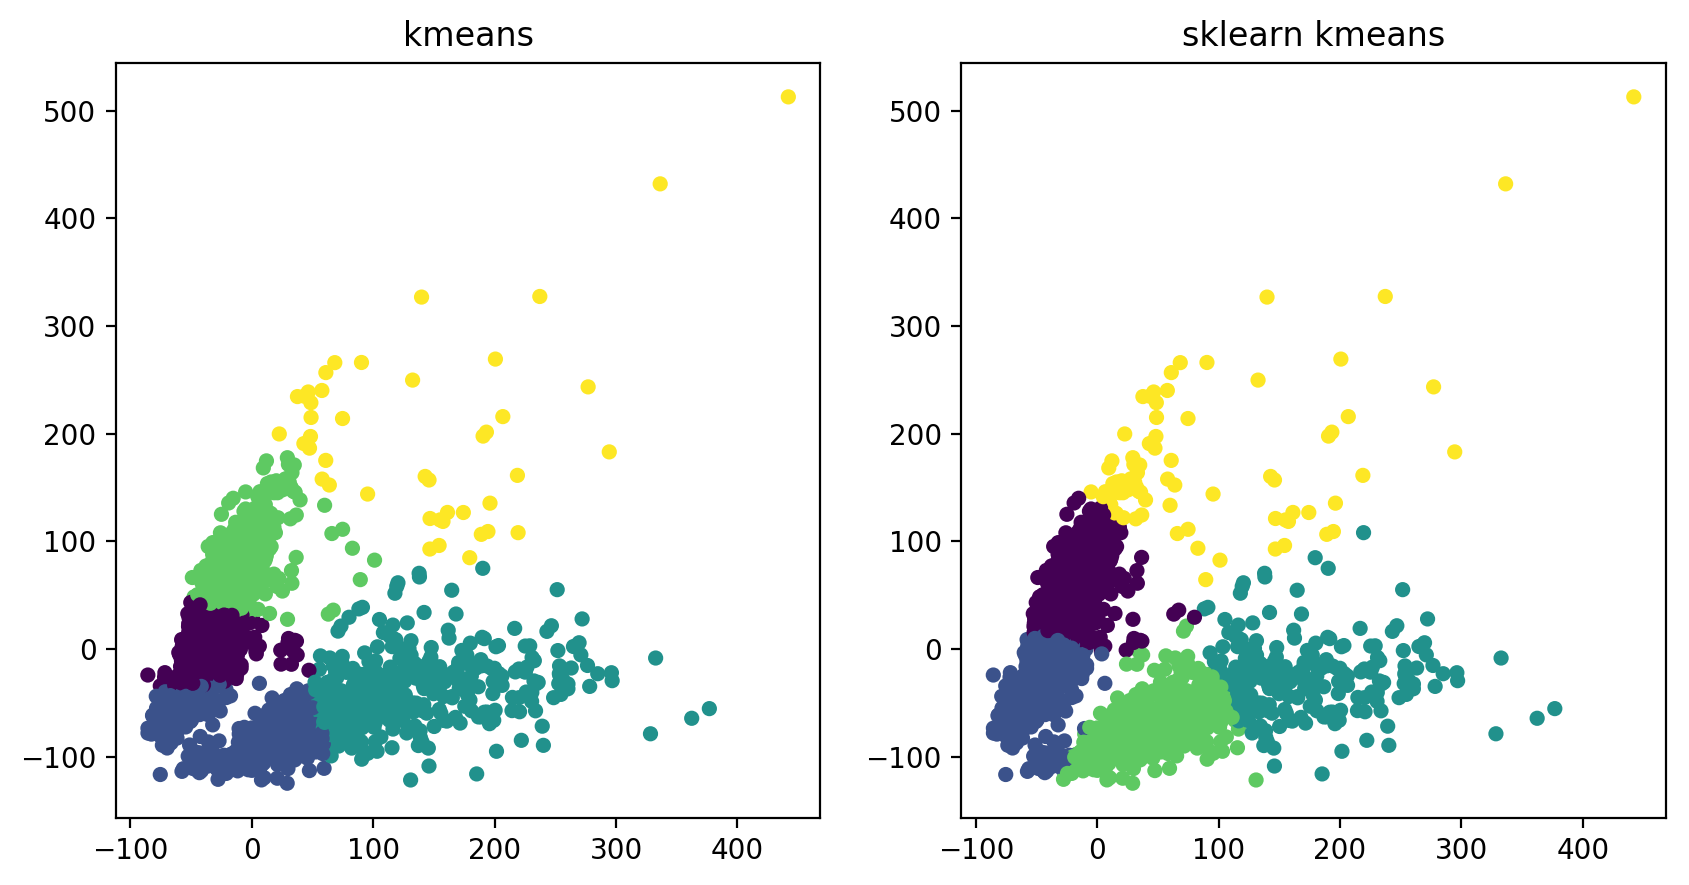

In [6]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), precision=2, separator=' ', suppress_small = False)
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


19 iterations were performed
Distances of clusters as compared to last generation: 
[0.04 0.   0.   0.04 0.  ]

kmeans:
runtime: 0:00:02.108865
centroids: 
 [-45.365 -31.604]
 [-20.866 47.717]
 [51.303 -68.500]
 [89.785 177.082]
 [174.242 -25.346]

sklearn kmeans:
runtime: 0:00:00.112045
centroids: 
 [-45.72 -33.25]
 [-21.43  46.13]
 [ 52.15 -68.04]
 [ 85.97 173.41]
 [174.54 -25.32]


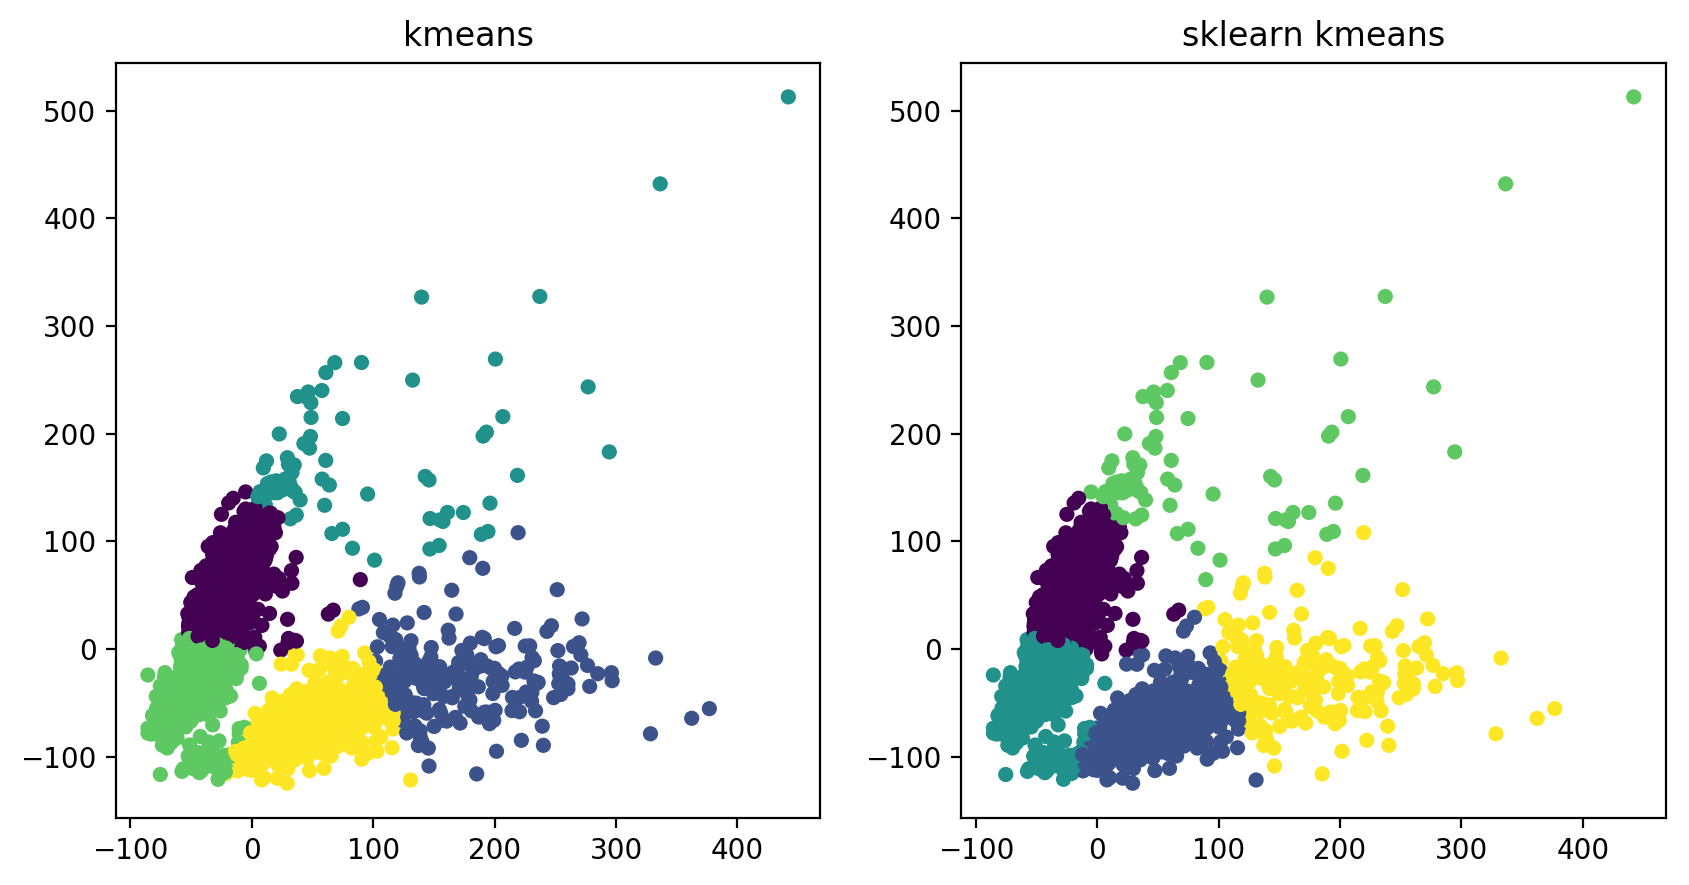

In [7]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), precision=2, separator=' ', suppress_small = False)
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], formatter={'float_kind':'{0:.3f}'.format}, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.
43 iterations were performed
Distances of clusters as compared to last generation: 
[0.   0.   0.06 0.06 0.07]

kmeans:
runtime: 0:00:06.520230
centroids: 
 [-35.301 3.049]
 [-25.857 -68.043]
 [-11.417 71.754]
 [133.880 -38.633]
 [142.029 199.534]

sklearn kmeans:
runtime: 0:00:00.111971
centroids: 
 [-45.75 -30.55]
 [-20.98  47.4 ]
 [ 46.53 -70.99]
 [ 85.97 173.41]
 [170.06 -26.32]


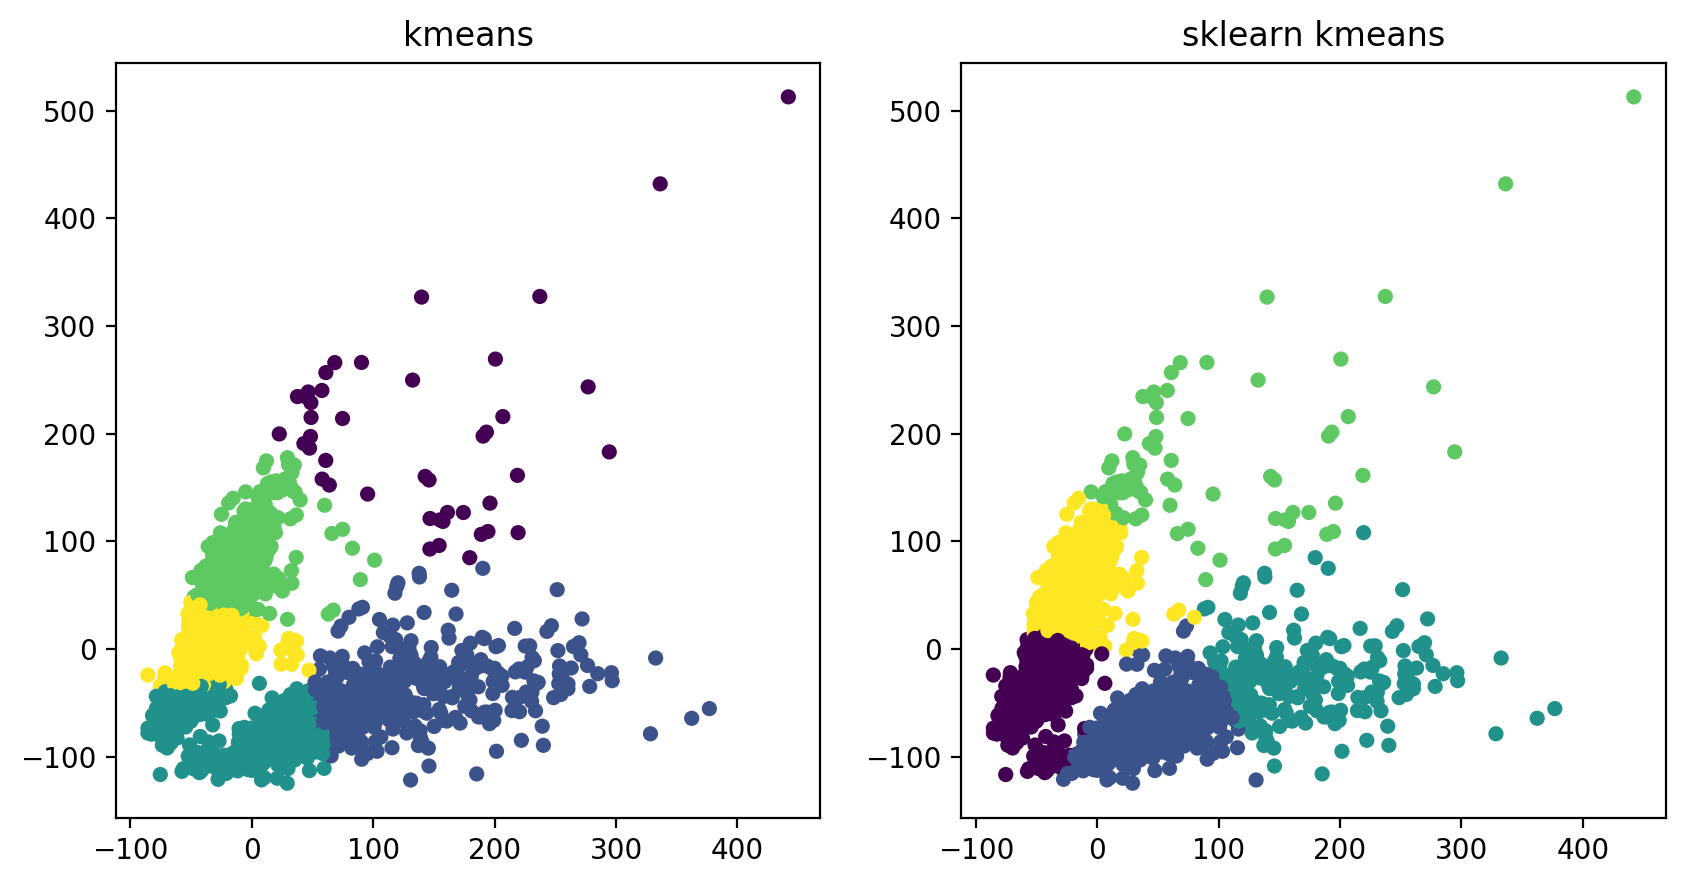

In [8]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), precision=2, separator=' ', suppress_small = False)
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], formatter={'float_kind':'{0:.3f}'.format})
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


Empty cluster! Correcting centroids.
19 iterations were performed
Distances of clusters as compared to last generation: 
[0.00 0.00 0.04 0.00 0.04]

kmeans:
runtime: 0:00:02.584642
centroids: 
 [-45.41 -31.59]
 [-20.88 47.68]
 [51.14 -68.55]
 [89.79 177.08]
 [174.24 -25.35]

sklearn kmeans:
runtime: 0:00:00.110247
centroids: 
 [-45.72 -33.25]
 [-21.43 46.13]
 [52.15 -68.04]
 [85.97 173.41]
 [174.54 -25.32]


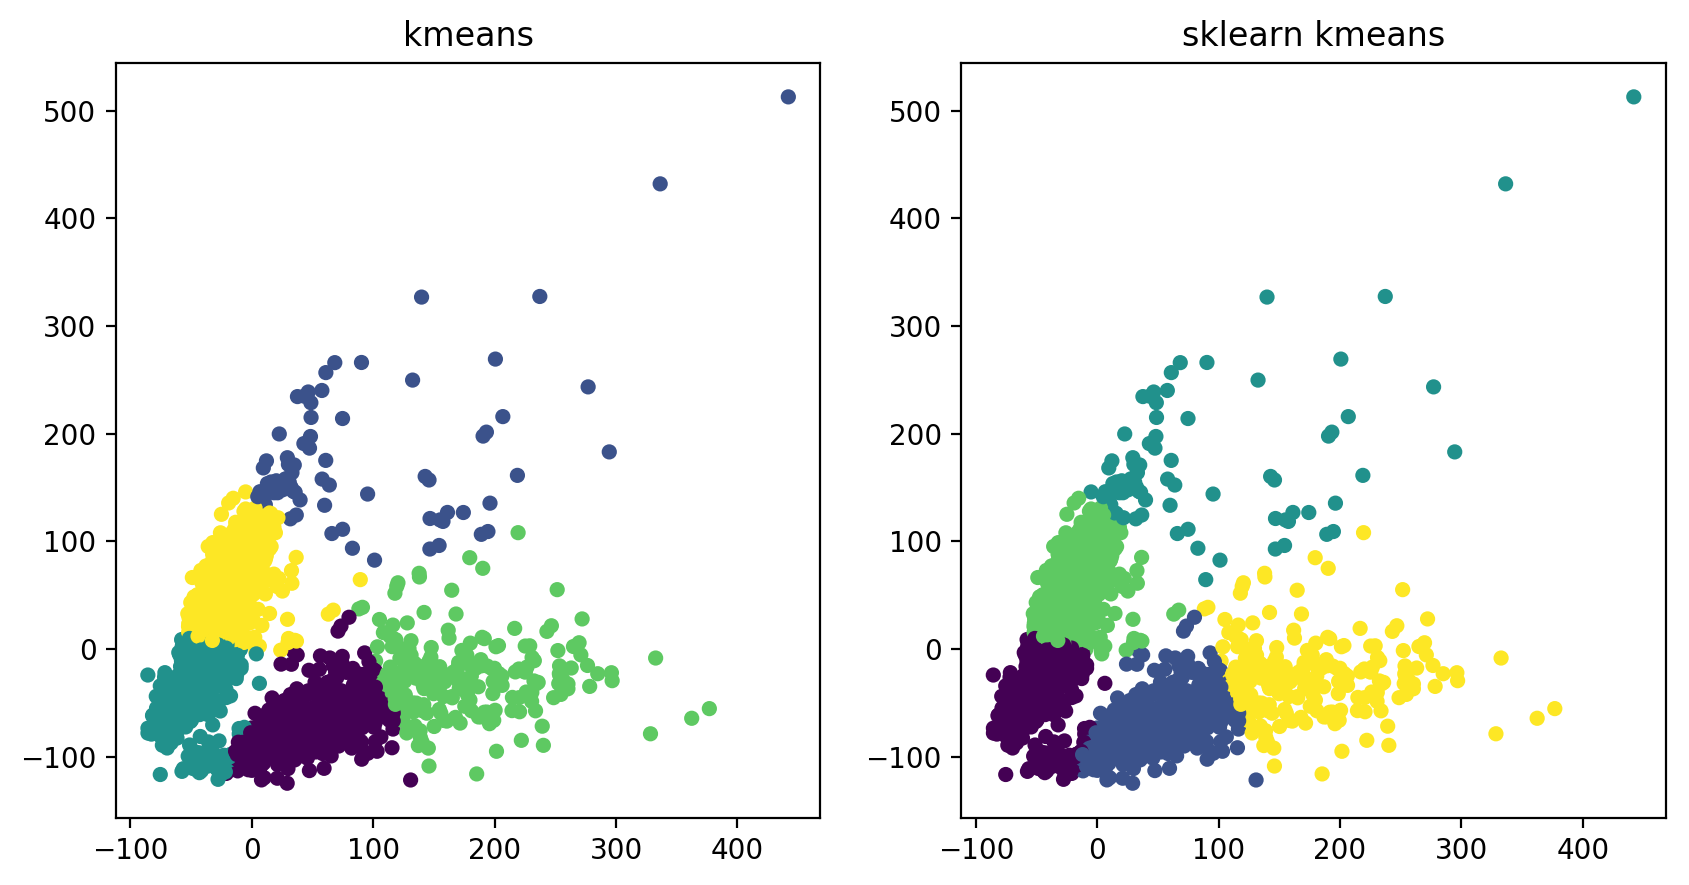

In [9]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), formatter={'float_kind':'{0:.2f}'.format})
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], formatter={'float_kind':'{0:.2f}'.format})
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], formatter={'float_kind':'{0:.2f}'.format})
print("centroids: \n" + ' ' + b_str[1:-1])


48 iterations were performed
Distances of clusters as compared to last generation: 
[0.00   0.06   0.07   0.06   0.00  ]

kmeans:
runtime: 0:00:06.890512
centroids: 
 [-35.30 3.05]
 [-25.86 -68.04]
 [-11.42 71.75]
 [133.88 -38.63]
 [142.03 199.53]

sklearn kmeans:
runtime: 0:00:00.111993
centroids: 
 [-45.72 -33.25]
 [-21.43 46.13]
 [52.15 -68.04]
 [85.97 173.41]
 [174.54 -25.32]


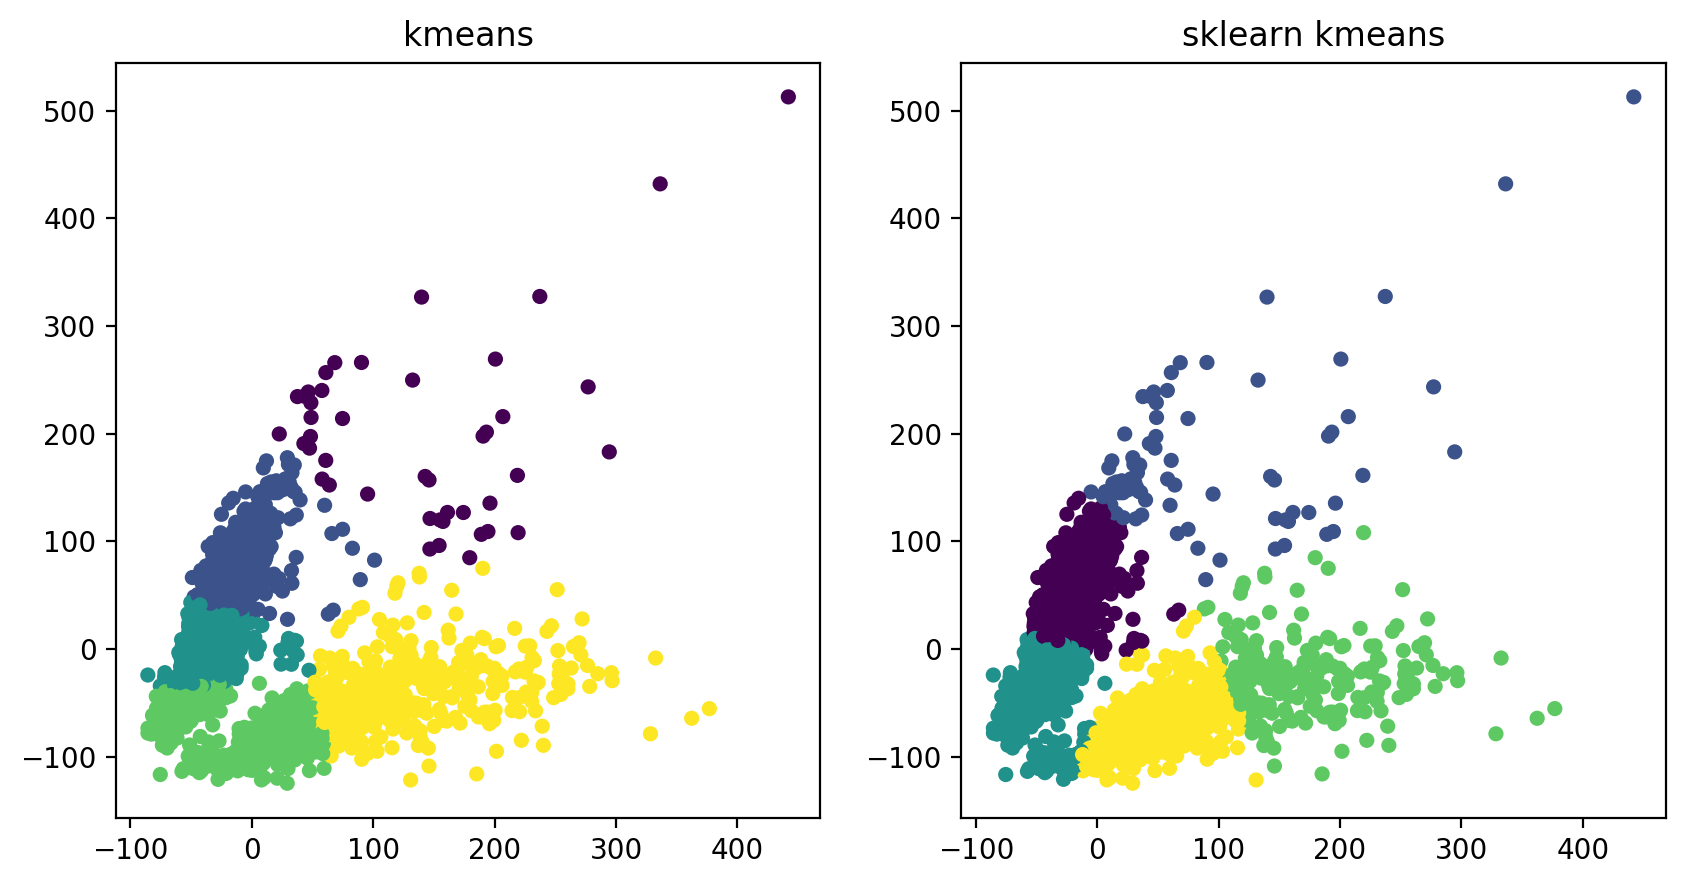

In [10]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), formatter={'float_kind':'{0:.2f}  '.format})
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], formatter={'float_kind':'{0:.2f}'.format})
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], formatter={'float_kind':'{0:.2f}'.format})
print("centroids: \n" + ' ' + b_str[1:-1])


52 iterations were performed
Distances of clusters as compared to last generation: 
[0.06     0.07     0.06     0.00     0.00    ]

kmeans:
runtime: 0:00:06.622075
centroids: 
 [-35.30 3.05]
 [-25.86 -68.04]
 [-11.42 71.75]
 [133.88 -38.63]
 [142.03 199.53]

sklearn kmeans:
runtime: 0:00:00.088614
centroids: 
 [-45.72 -33.25]
 [-21.43 46.13]
 [52.15 -68.04]
 [85.97 173.41]
 [174.54 -25.32]


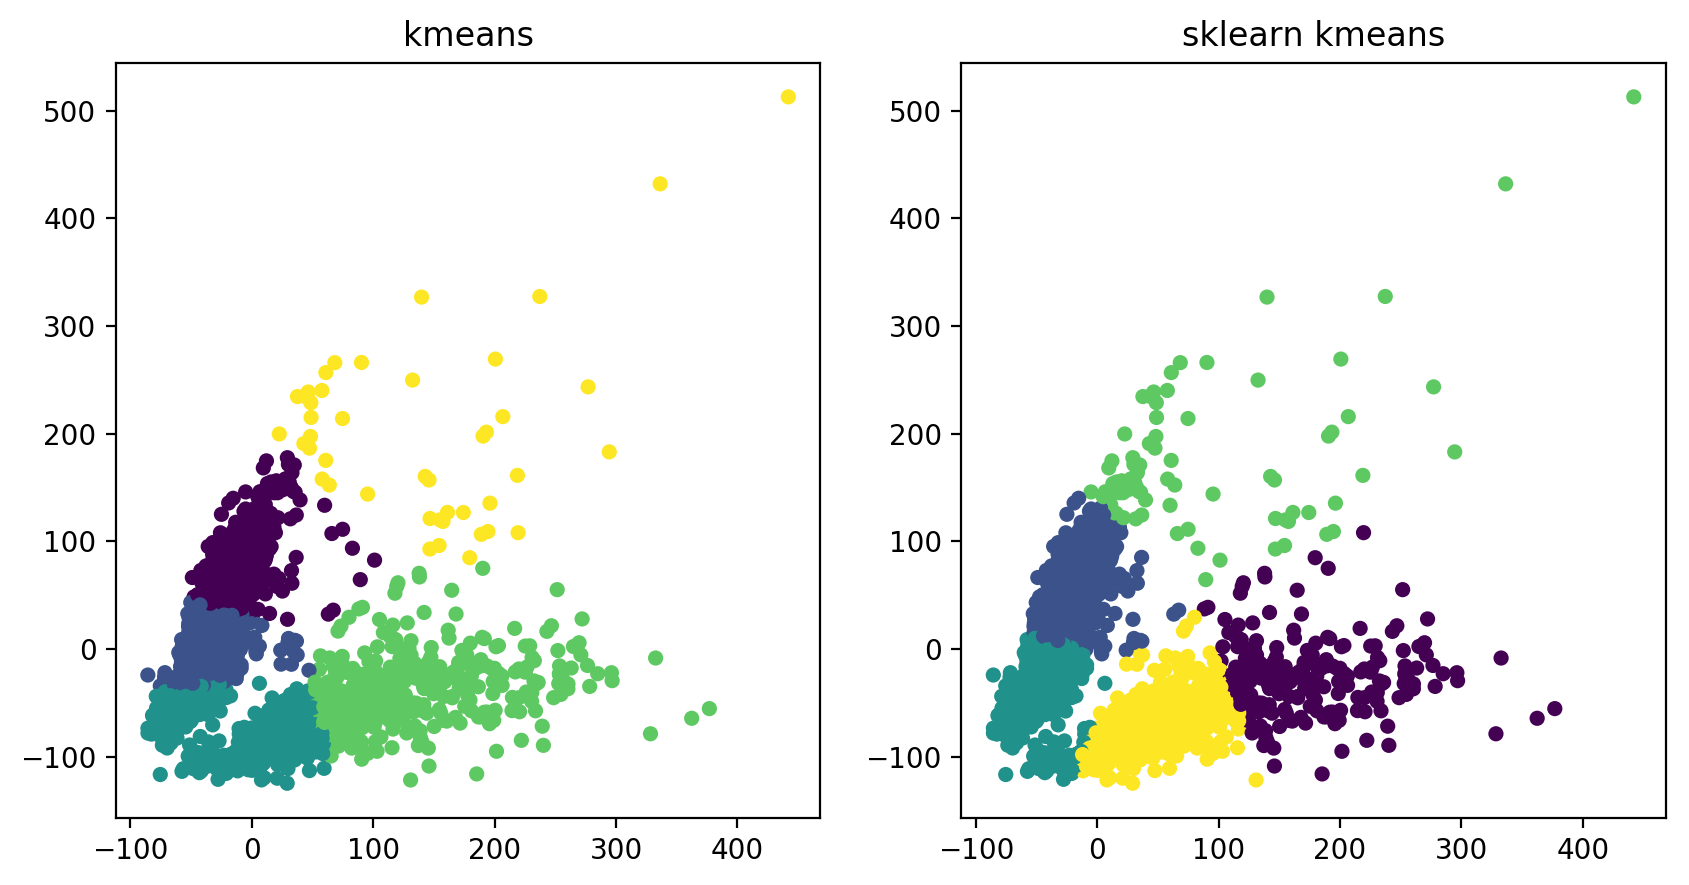

In [11]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), formatter={'float_kind':'{0:.2f}    '.format})
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], formatter={'float_kind':'{0:.2f}'.format})
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], formatter={'float_kind':'{0:.2f}'.format})
print("centroids: \n" + ' ' + b_str[1:-1])


49 iterations were performed
Distances of clusters as compared to last generation: 
[0.07   0.00   0.00   0.06   0.06  ]

kmeans:
runtime: 0:00:05.363095
centroids: 
 [-35.30   3.05  ]
 [-25.86   -68.04  ]
 [-11.42   71.75  ]
 [133.88   -38.63  ]
 [142.03   199.53  ]

sklearn kmeans:
runtime: 0:00:00.098745
centroids: 
 [-45.72 -33.25]
 [-21.43 46.13]
 [52.15 -68.04]
 [85.97 173.41]
 [174.54 -25.32]


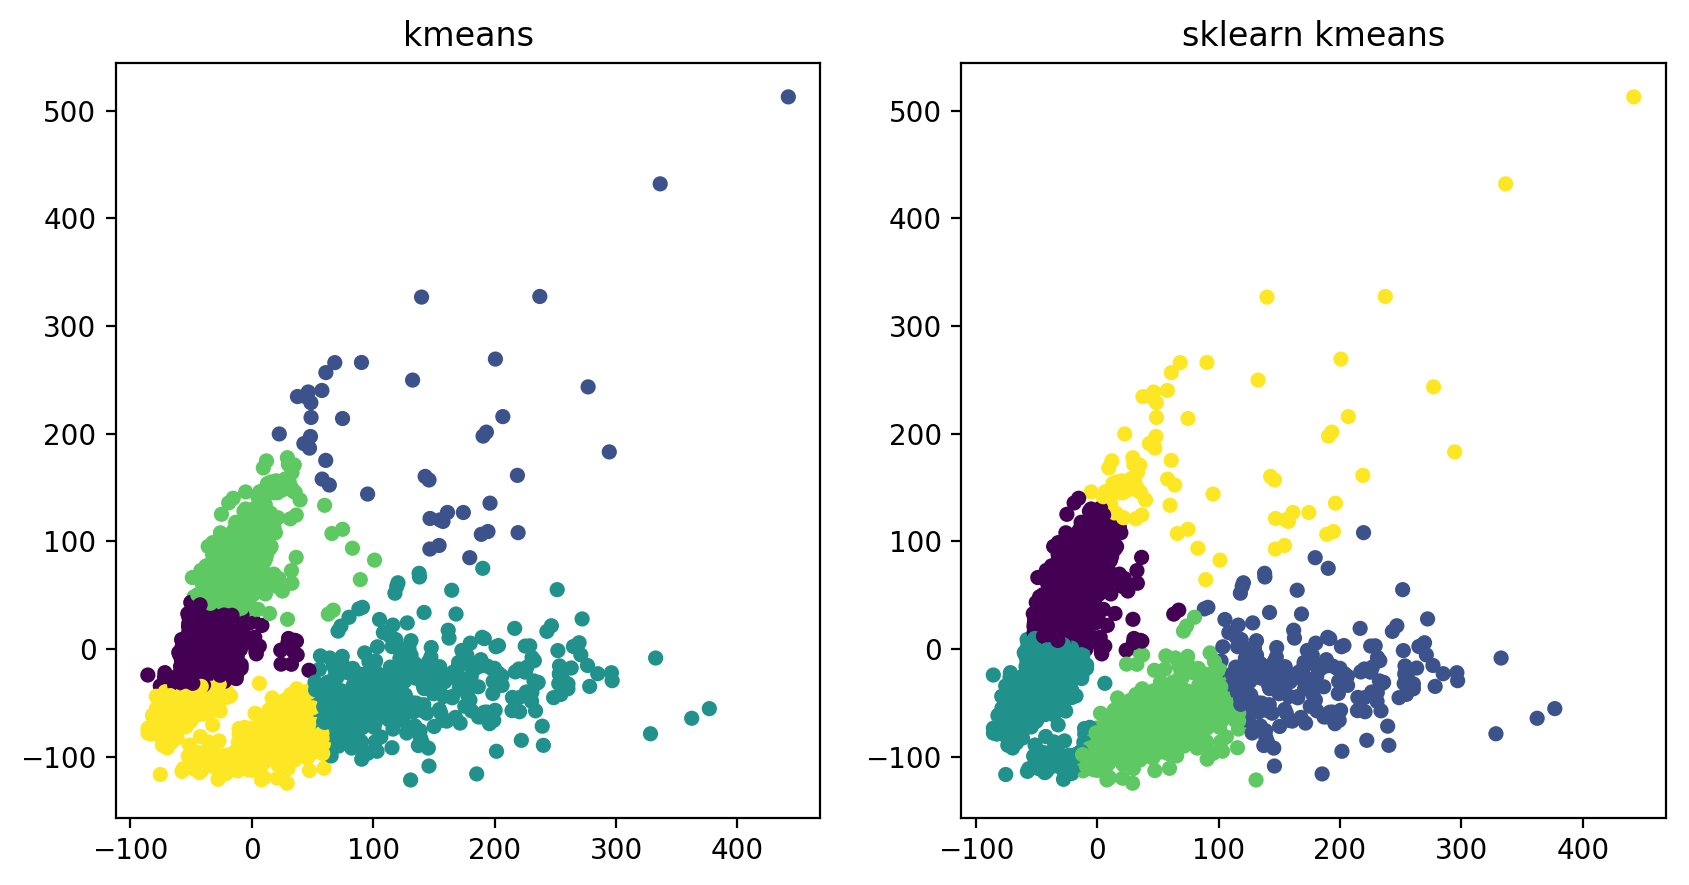

In [12]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), formatter={'float_kind':'{0:.2f}  '.format})
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], formatter={'float_kind':'{0:.2f}  '.format})
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], formatter={'float_kind':'{0:.2f}'.format})
print("centroids: \n" + ' ' + b_str[1:-1])


Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.
21 iterations were performed
Distances of clusters as compared to last generation: 
[0.04   0.00   0.00   0.04   0.00  ]

kmeans:
runtime: 0:00:02.455512
centroids: 
 [-45.72  -33.25]
 [-21.43  46.13]
 [52.15  -68.04]
 [85.97  173.41]
 [174.54  -25.32]

sklearn kmeans:
runtime: 0:00:00.088036
centroids: 
 [-45.72 -33.25]
 [-21.43 46.13]
 [52.15 -68.04]
 [85.97 173.41]
 [174.54 -25.32]


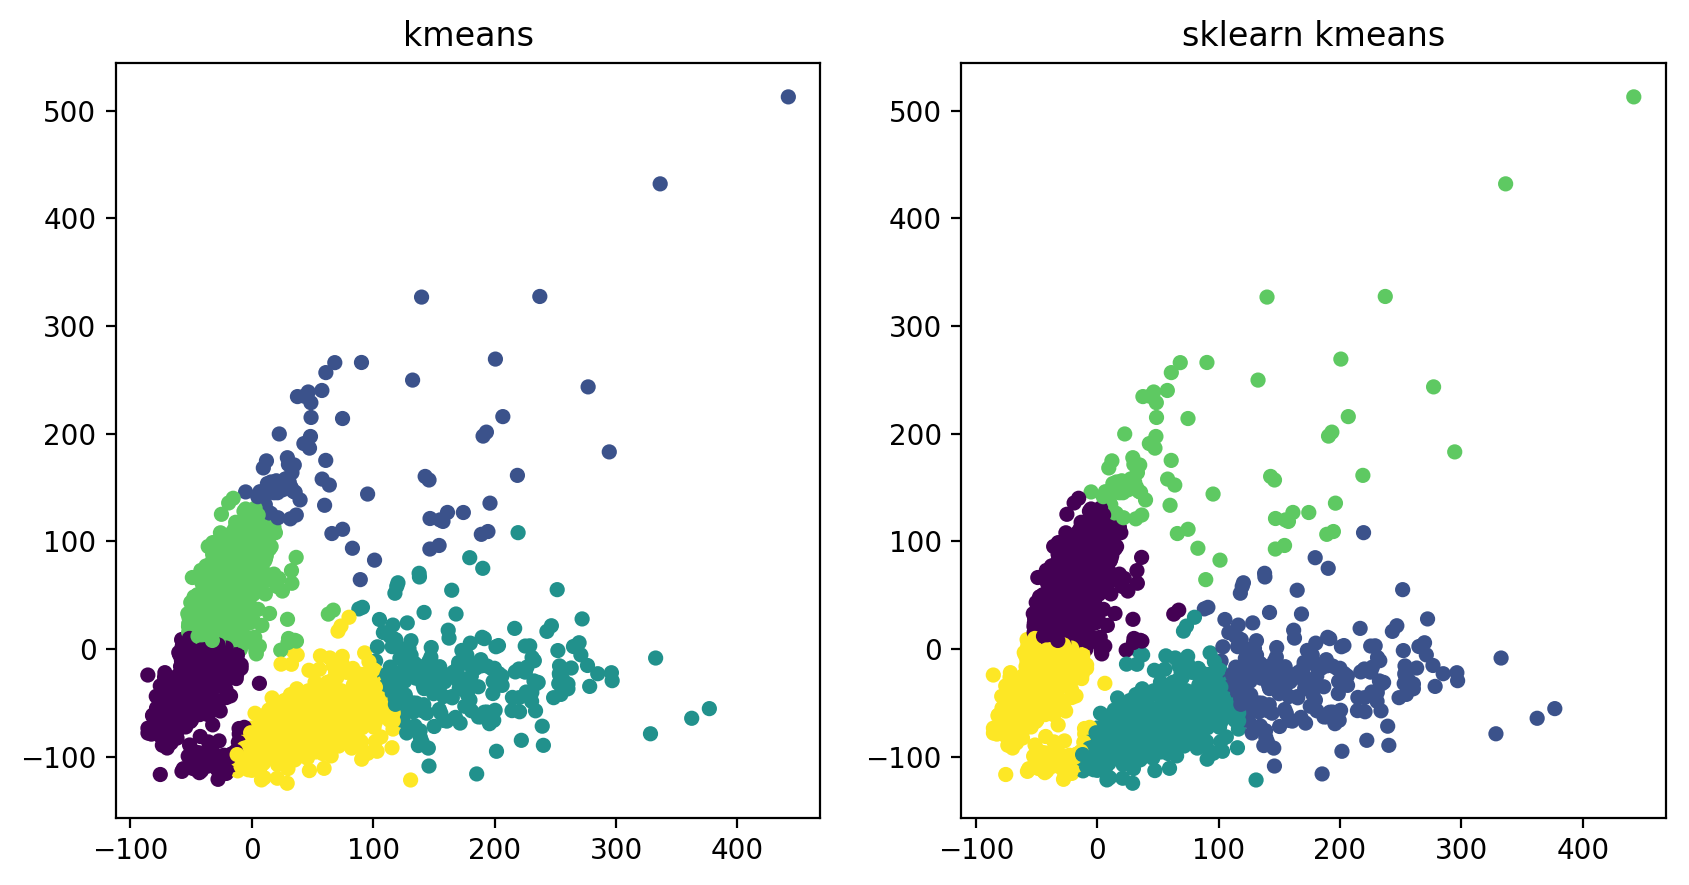

In [13]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), formatter={'float_kind':'{0:.2f}  '.format})
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], formatter={'float_kind':'{0:.2f}'.format}, separator = '  ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], formatter={'float_kind':'{0:.2f}'.format})
print("centroids: \n" + ' ' + b_str[1:-1])


Empty cluster! Correcting centroids.
23 iterations were performed
Distances of clusters as compared to last generation: 
[0.00   0.00   0.08   0.00   0.08  ]

kmeans:
runtime: 0:00:02.848945
centroids: 
 [-45.51,  -28.26],
 [-20.06,  49.41],
 [42.84,  -72.53],
 [94.79,  177.74],
 [167.11,  -28.12]

sklearn kmeans:
runtime: 0:00:00.083998
centroids: 
 [-45.76 -30.39]
 [-20.95 47.47]
 [46.34 -71.08]
 [85.97 173.41]
 [170.06 -26.32]


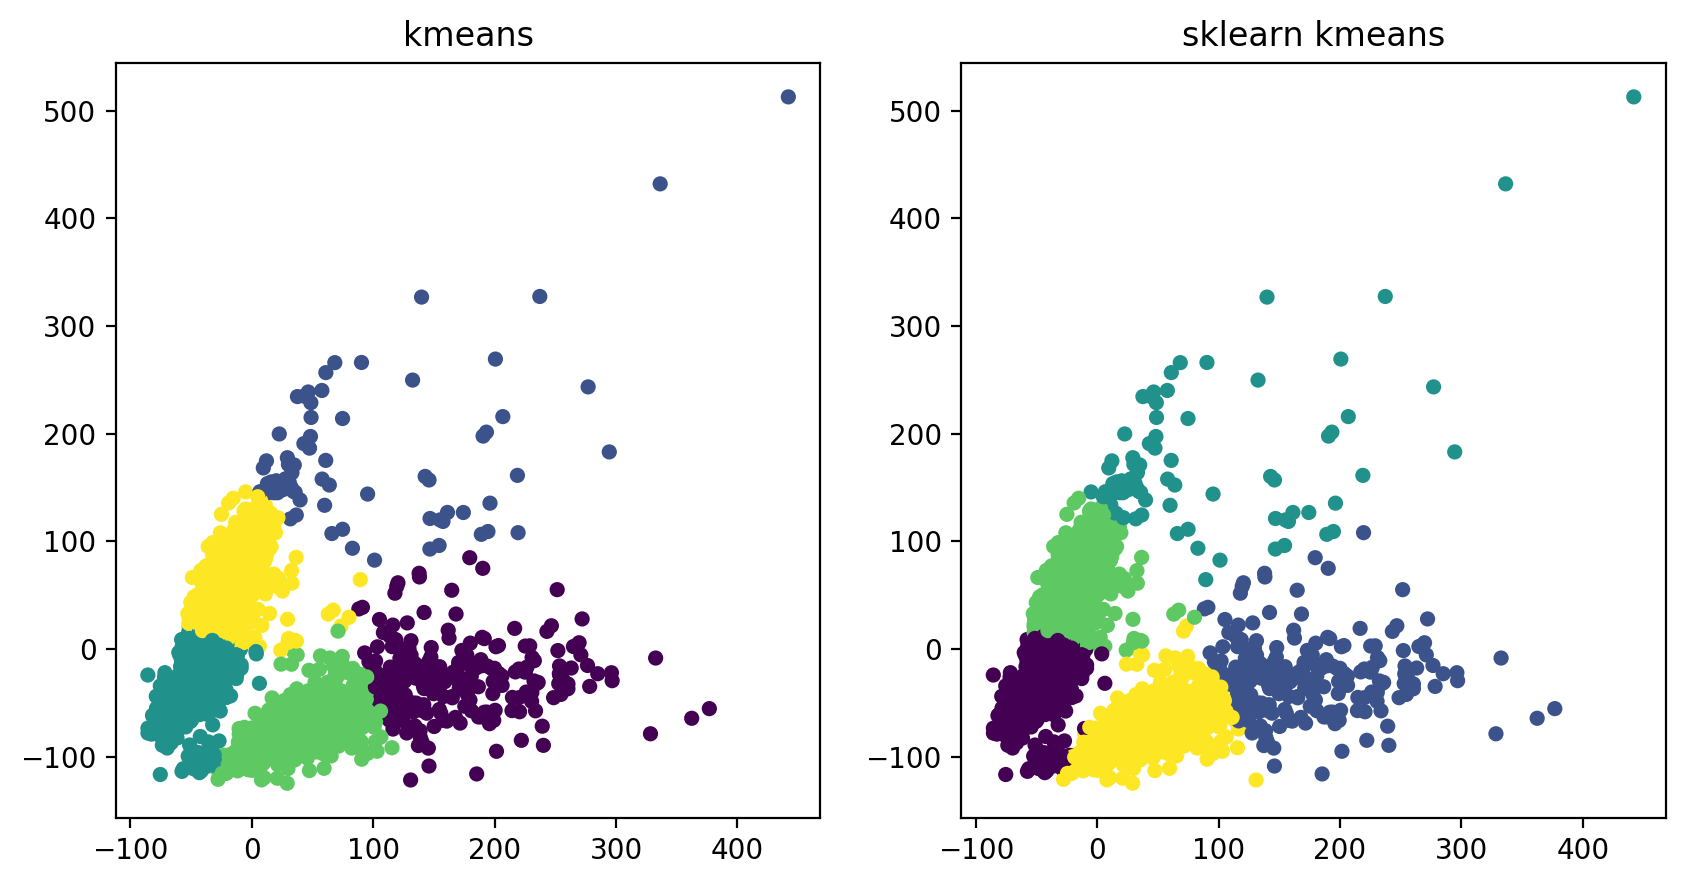

In [14]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), formatter={'float_kind':'{0:.2f}  '.format})
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], formatter={'float_kind':'{0:.2f}'.format}, separator = ',  ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], formatter={'float_kind':'{0:.2f}'.format})
print("centroids: \n" + ' ' + b_str[1:-1])


Empty cluster! Correcting centroids.
50 iterations were performed
Distances of clusters as compared to last generation: 
[0.00   0.00   0.06   0.07   0.06  ]

kmeans:
runtime: 0:00:06.386095
centroids: 
 [-35.30  ,  3.05  ],
 [-25.86  ,  -68.04  ],
 [-11.42  ,  71.75  ],
 [133.88  ,  -38.63  ],
 [142.03  ,  199.53  ]

sklearn kmeans:
runtime: 0:00:00.100000
centroids: 
 [-45.72 -33.25]
 [-21.43 46.13]
 [52.15 -68.04]
 [85.97 173.41]
 [174.54 -25.32]


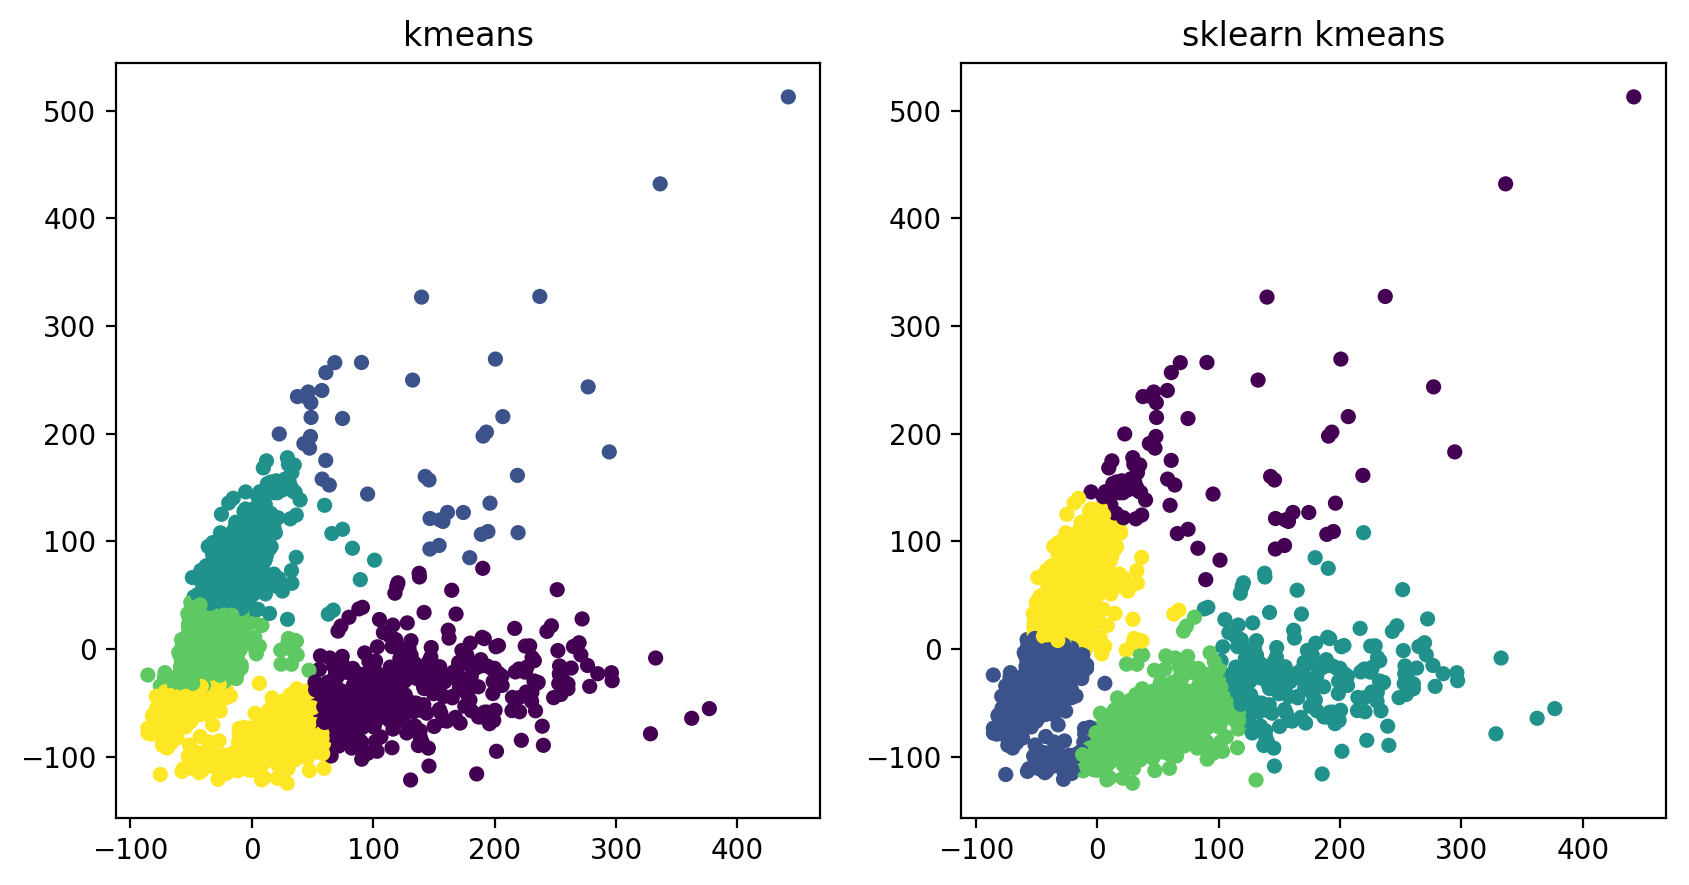

In [15]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), formatter={'float_kind':'{0:.2f}  '.format})
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], formatter={'float_kind':'{0:.2f}  '.format}, separator = ',  ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], formatter={'float_kind':'{0:.2f}'.format})
print("centroids: \n" + ' ' + b_str[1:-1])


Empty cluster! Correcting centroids.
21 iterations were performed
Distances of clusters as compared to last generation: 
[0.20   0.00   0.00   0.00   0.08  ]

kmeans:
runtime: 0:00:02.464800
centroids: 
 [-45.46    -28.49  ]
 [-20.06    49.41  ]
 [44.39    -72.00  ]
 [94.79    177.74  ]
 [168.59    -27.44  ]

sklearn kmeans:
runtime: 0:00:00.096770
centroids: 
 [-45.75 -30.51]
 [-20.96 47.44]
 [46.53 -70.99]
 [85.97 173.41]
 [170.06 -26.32]


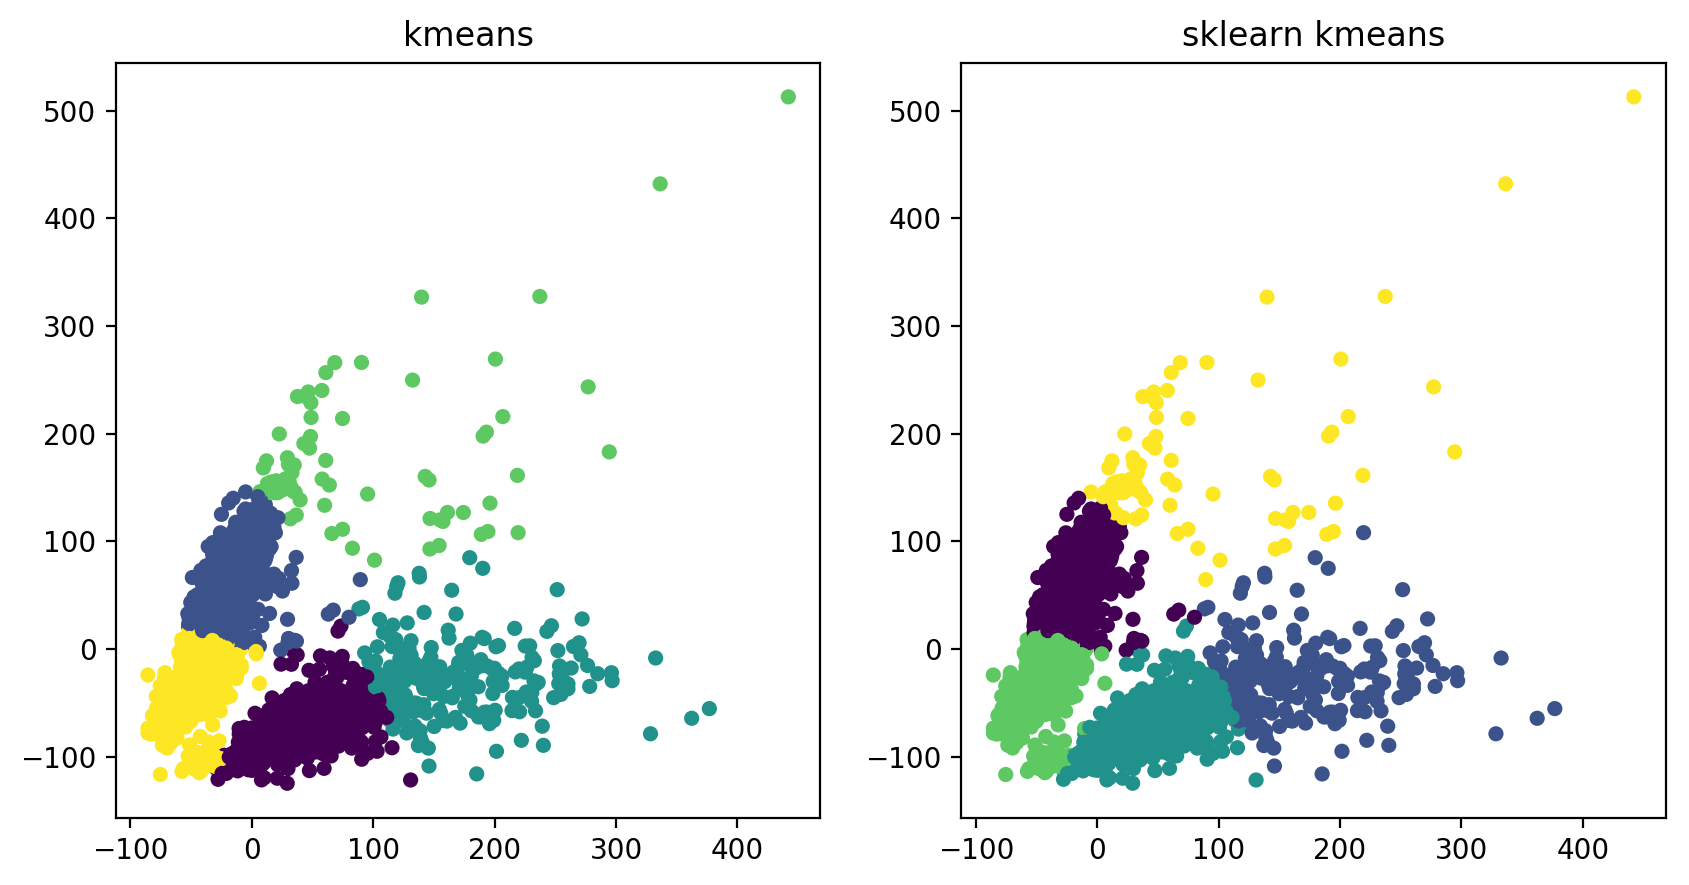

In [16]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), formatter={'float_kind':'{0:.2f}  '.format})
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], formatter={'float_kind':'{0:.2f}  '.format}, separator = '  ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], formatter={'float_kind':'{0:.2f}'.format})
print("centroids: \n" + ' ' + b_str[1:-1])


Empty cluster! Correcting centroids.
20 iterations were performed
Distances of clusters as compared to last generation: 
[0.00   0.08   0.08   0.00   0.00  ]

kmeans:
runtime: 0:00:02.709724
centroids: 
 [-45.51      -28.26    ]
 [-20.06      49.41    ]
 [42.84      -72.53    ]
 [94.79      177.74    ]
 [167.11      -28.12    ]

sklearn kmeans:
runtime: 0:00:00.084019
centroids: 
 [-45.72 -33.25]
 [-21.43 46.13]
 [52.15 -68.04]
 [85.97 173.41]
 [174.54 -25.32]


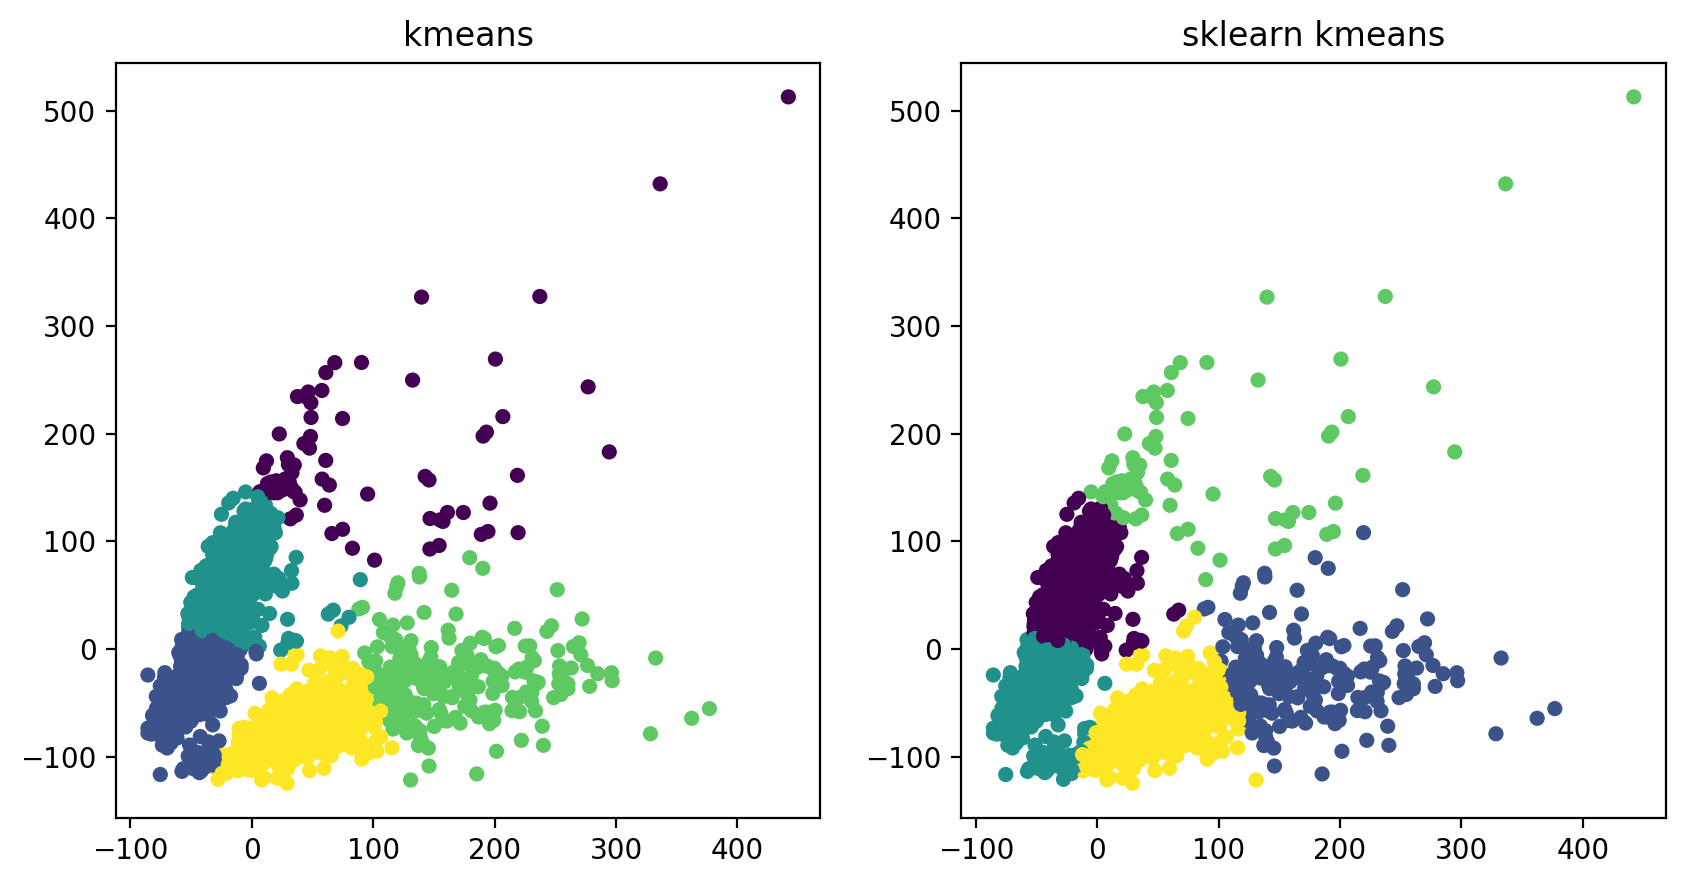

In [17]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), formatter={'float_kind':'{0:.2f}  '.format})
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], formatter={'float_kind':'{0:.2f}    '.format}, separator = '  ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], formatter={'float_kind':'{0:.2f}'.format})
print("centroids: \n" + ' ' + b_str[1:-1])


In [18]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), formatter={'float_kind':'{0:.2f}  '.format})
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], formatter={'float_kind':'{0:.2f}'.format}, separator = '  ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], formatter={'float_kind':'{0:.2f}'.format})
print("centroids: \n" + ' ' + b_str[1:-1])


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.
24 iterations were performed
Distances of clusters as compared to last generation: 
[0.08   0.00   0.00   0.08   0.00  ]

kmeans:
runtime: 0:00:03.437924
centroids: 
 [-45.51  -28.26]
 [-20.06  49.41]
 [42.84  -72.53]
 [94.79  177.74]
 [167.11  -28.12]

sklearn kmeans:
runtime: 0:00:00.104756
centroids: 
 [-45.70 -33.17]
 [-21.40 46.20]
 [52.15 -68.04]
 [85.97 173.41]
 [174.54 -25.32]


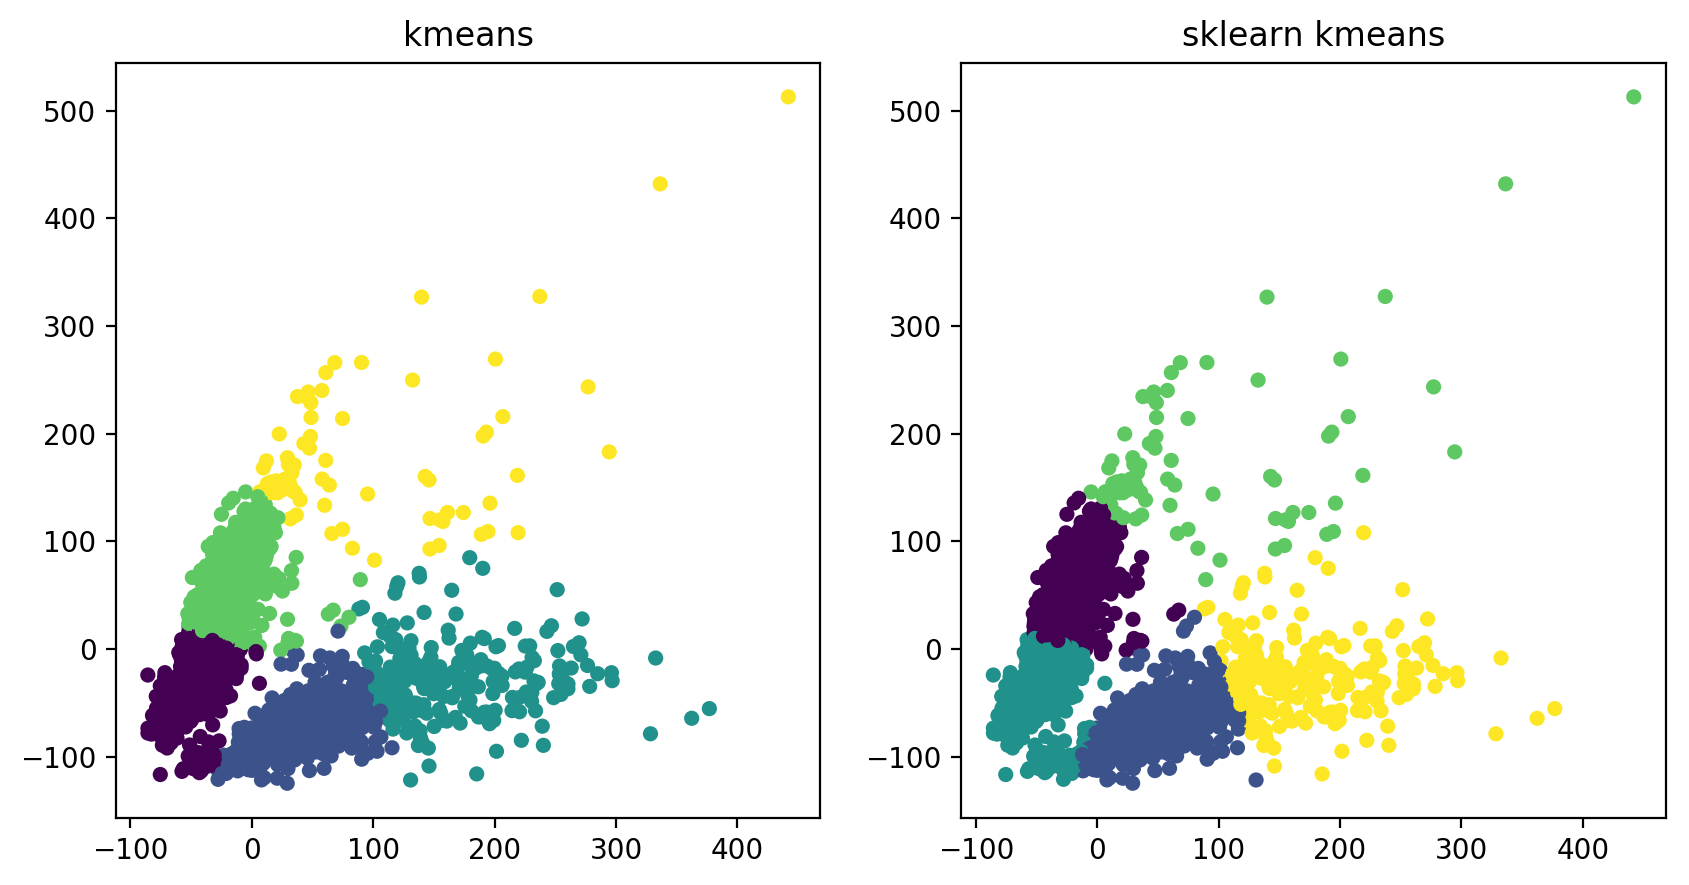

In [19]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), formatter={'float_kind':'{0:.2f}  '.format})
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], formatter={'float_kind':'{0:.2f}'.format}, separator = '  ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], formatter={'float_kind':'{0:.2f}'.format})
print("centroids: \n" + ' ' + b_str[1:-1])


47 iterations were performed
Distances of clusters as compared to last generation: 
[0.00   0.00   0.06   0.07   0.06  ]

kmeans:
runtime: 0:00:06.348344
centroids: 
 [-35.30  3.05]
 [-25.86  -68.04]
 [-11.42  71.75]
 [133.88  -38.63]
 [142.03  199.53]

sklearn kmeans:
runtime: 0:00:00.108002
centroids: 
 [-45.72 -33.25]
 [-21.43 46.13]
 [52.15 -68.04]
 [85.97 173.41]
 [174.54 -25.32]


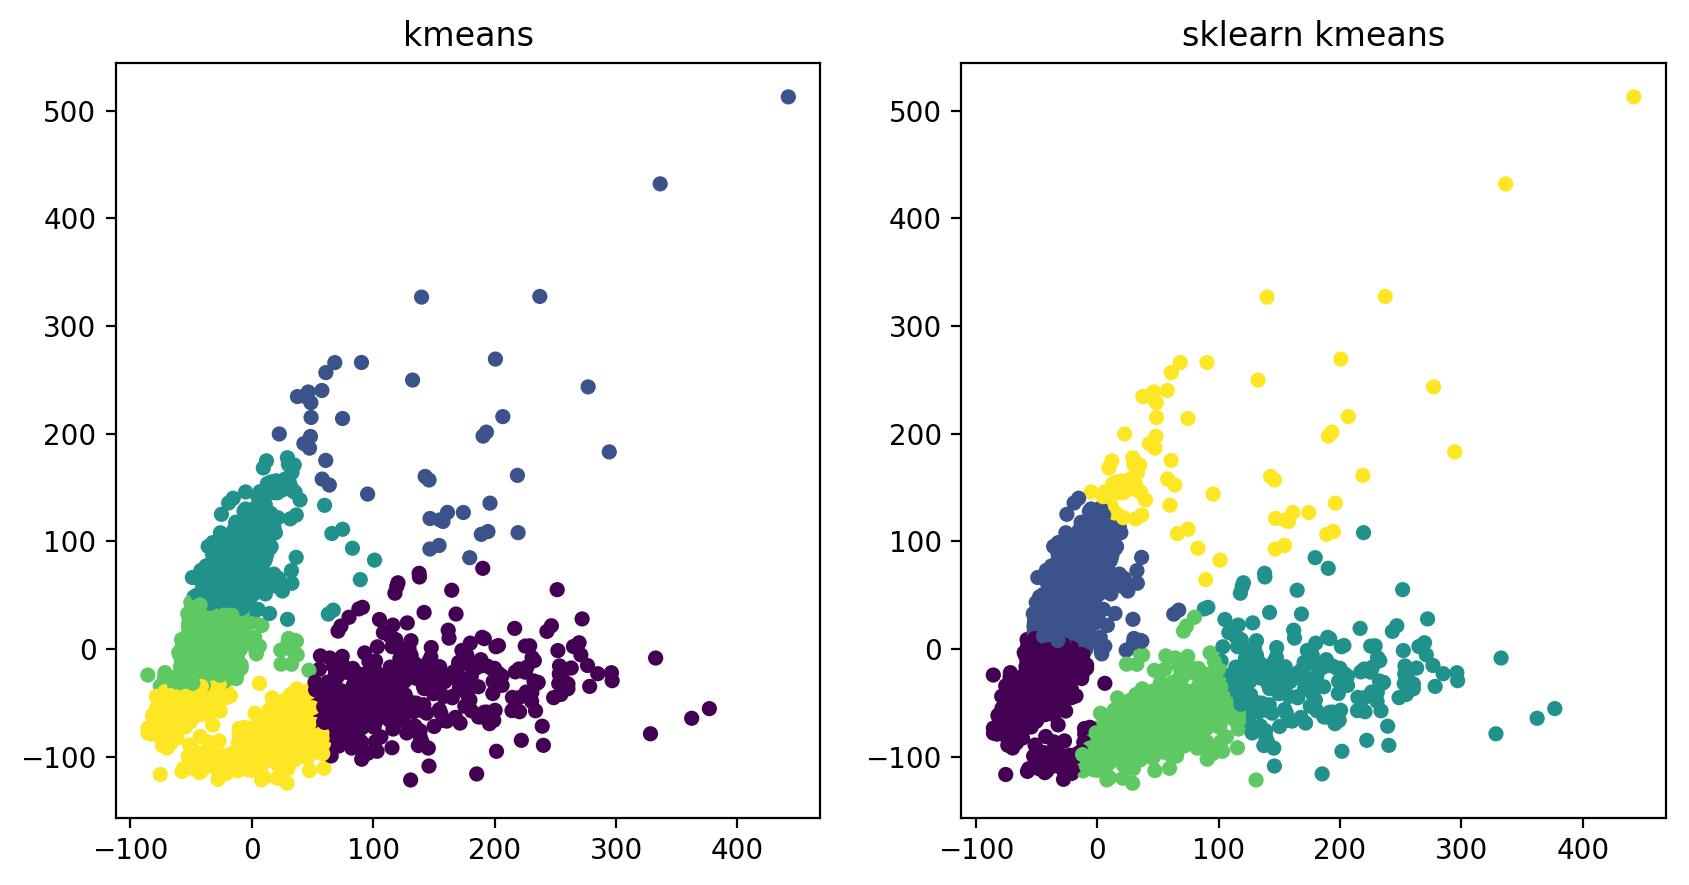

In [20]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), formatter={'float_kind':'{0:.2f}  '.format})
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], formatter={'float_kind':lambda x: "%.2f" % x}, separator = '  ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], formatter={'float_kind':'{0:.2f}'.format})
print("centroids: \n" + ' ' + b_str[1:-1])


In [21]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), formatter={'float_kind':'{0:.2f}  '.format})
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], formatter={'float_kind': "%.2f" % x}, separator = '  ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], formatter={'float_kind':'{0:.2f}'.format})
print("centroids: \n" + ' ' + b_str[1:-1])


20 iterations were performed
Distances of clusters as compared to last generation: 
[0.00   0.00   0.00   0.08   0.08  ]

kmeans:
runtime: 0:00:02.821225


NameError: name 'x' is not defined

Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.
18 iterations were performed
Distances of clusters as compared to last generation: 
[0.08 0.00 0.00 0.00 0.08]

kmeans:
runtime: 0:00:02.585059
centroids: 
 [-45.48  -28.42]
 [-20.06  49.41]
 [44.21  -72.08]
 [94.79  177.74]
 [168.59  -27.44]

sklearn kmeans:
runtime: 0:00:00.115041
centroids: 
 [-45.72  -33.25]
 [-21.43  46.13]
 [52.15  -68.04]
 [85.97  173.41]
 [174.54  -25.32]


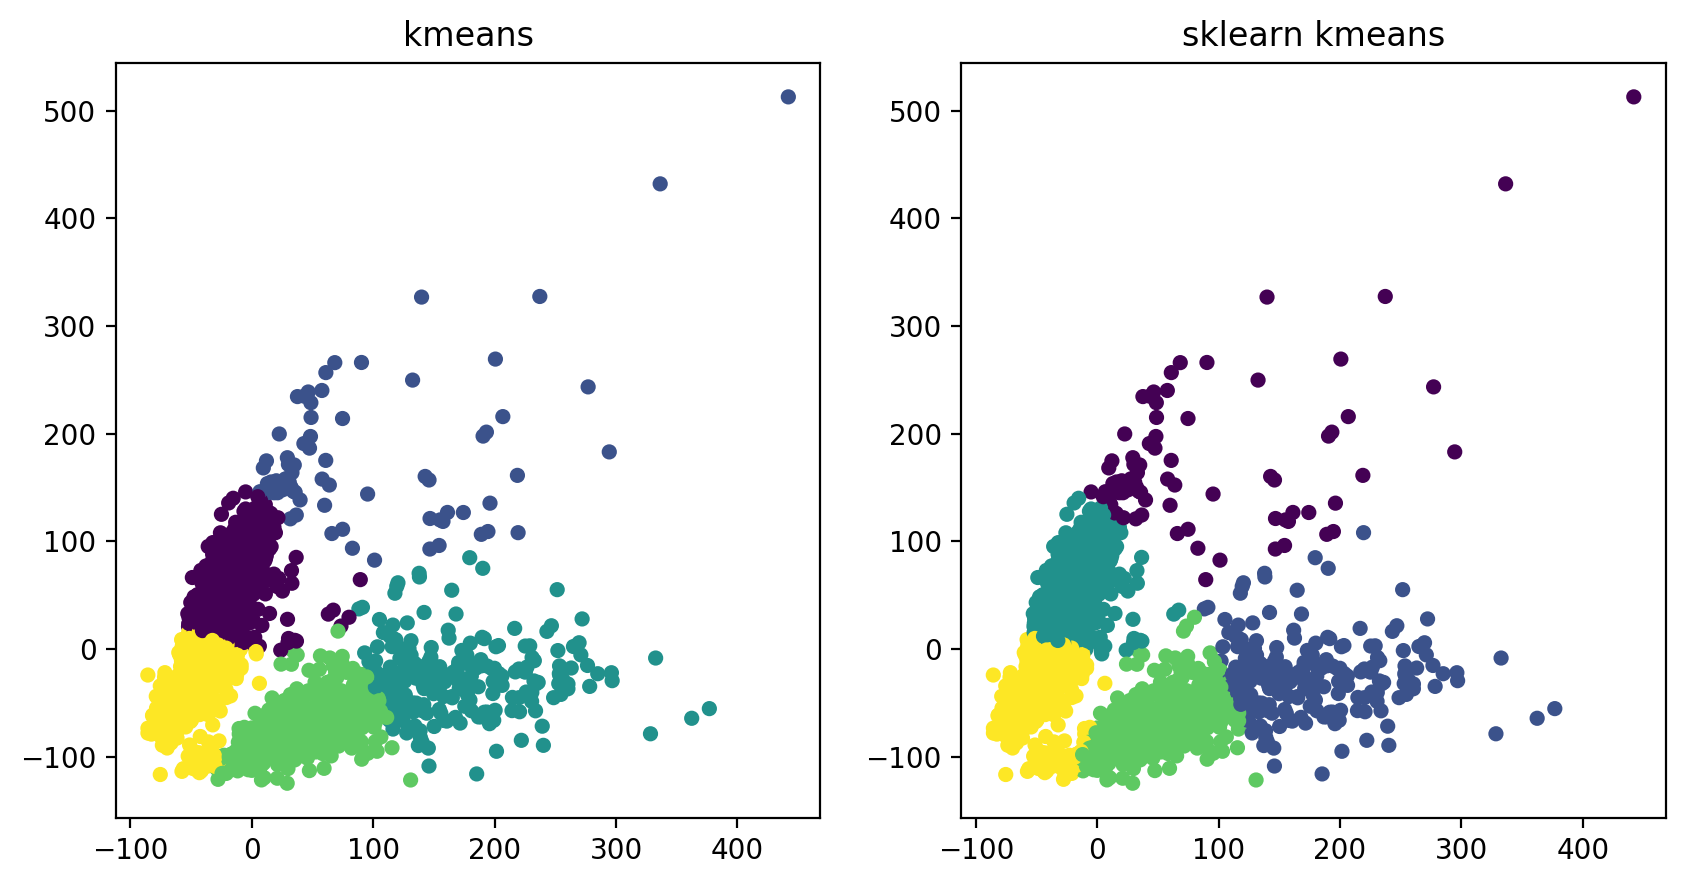

In [22]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), formatter={'float_kind':lambda x: "%.2f" % x})
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], formatter={'float_kind':lambda x: "%.2f" % x}, separator = '  ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], formatter={'float_kind':lambda x: "%.2f" % x}, separator = '  ')
print("centroids: \n" + ' ' + b_str[1:-1])


Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.
18 iterations were performed
Distances of clusters as compared to last generation: 
[0.00 0.00 0.04 0.00 0.04]

kmeans:
runtime: 0:00:02.611057
centroids: 
 [-45.41  -31.72]
 [-20.90  47.60]
 [51.30  -68.50]
 [89.79  177.08]
 [174.24  -25.35]

sklearn kmeans:
runtime: 0:00:00.084004
centroids: 
 [%.2f  %.2f]
 [%.2f  %.2f]
 [%.2f  %.2f]
 [%.2f  %.2f]
 [%.2f  %.2f]


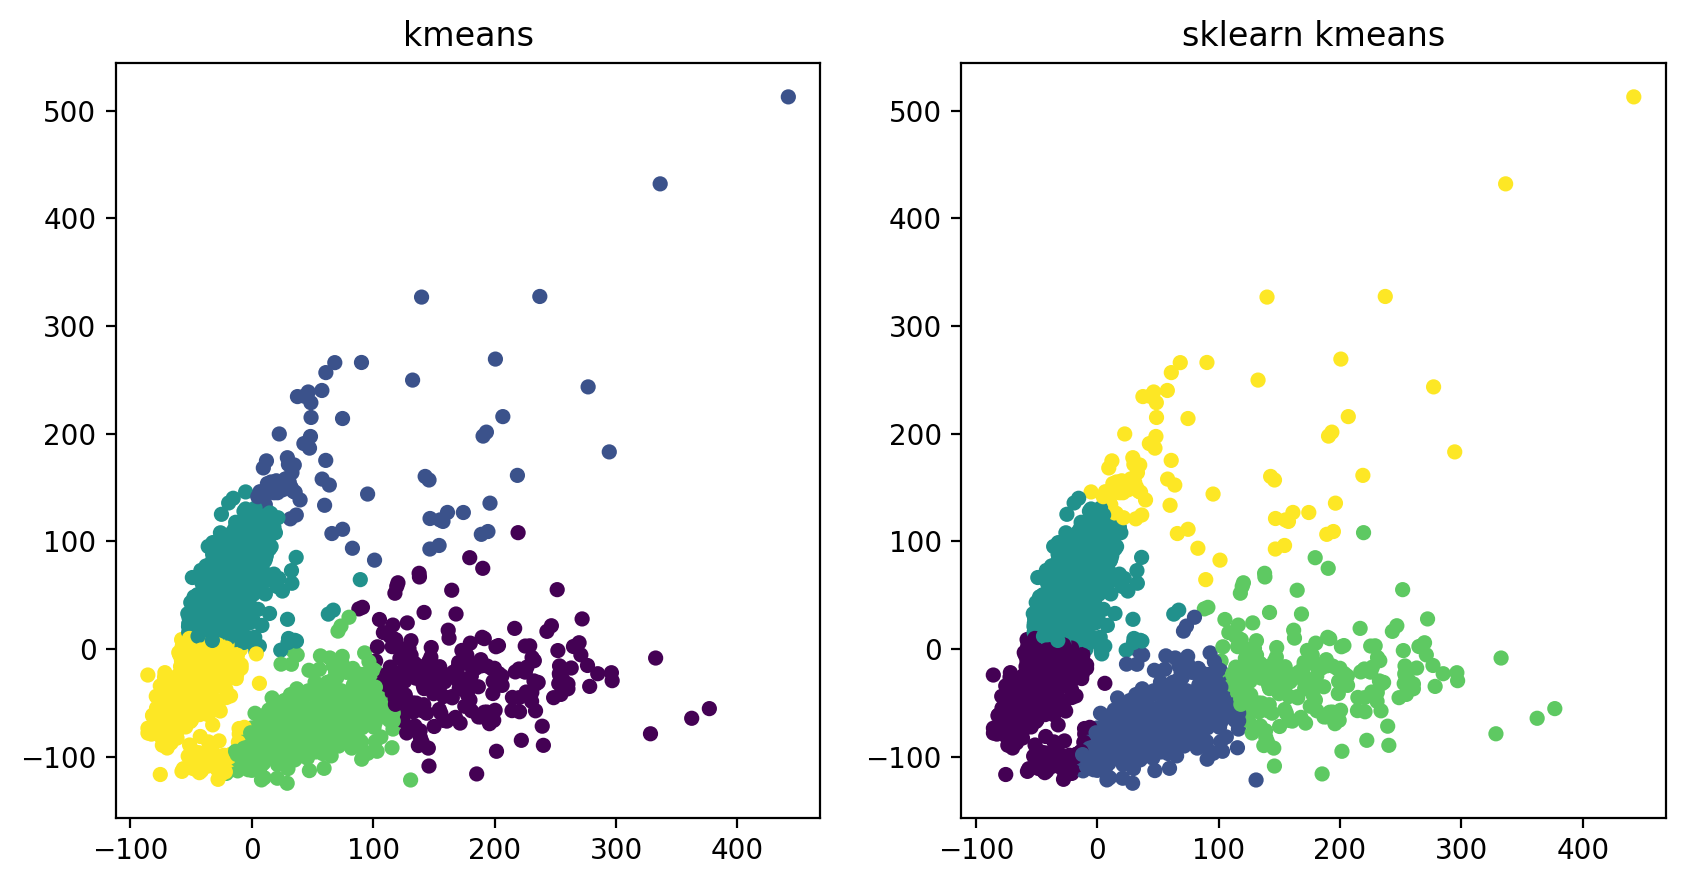

In [23]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), formatter={'float_kind':lambda x: "%.2f" % x})
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], formatter={'float_kind':lambda x: "%.2f" % x}, separator = '  ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], formatter={'float_kind':lambda x: "%.2f"}, separator = '  ')
print("centroids: \n" + ' ' + b_str[1:-1])


Empty cluster! Correcting centroids.
50 iterations were performed
Distances of clusters as compared to last generation: 
[0.06 0.07 0.00 0.00 0.06]

kmeans:
runtime: 0:00:06.109836
centroids: 
 [-35.30  3.05]
 [-25.86  -68.04]
 [-11.42  71.75]
 [133.88  -38.63]
 [142.03  199.53]

sklearn kmeans:
runtime: 0:00:00.089376


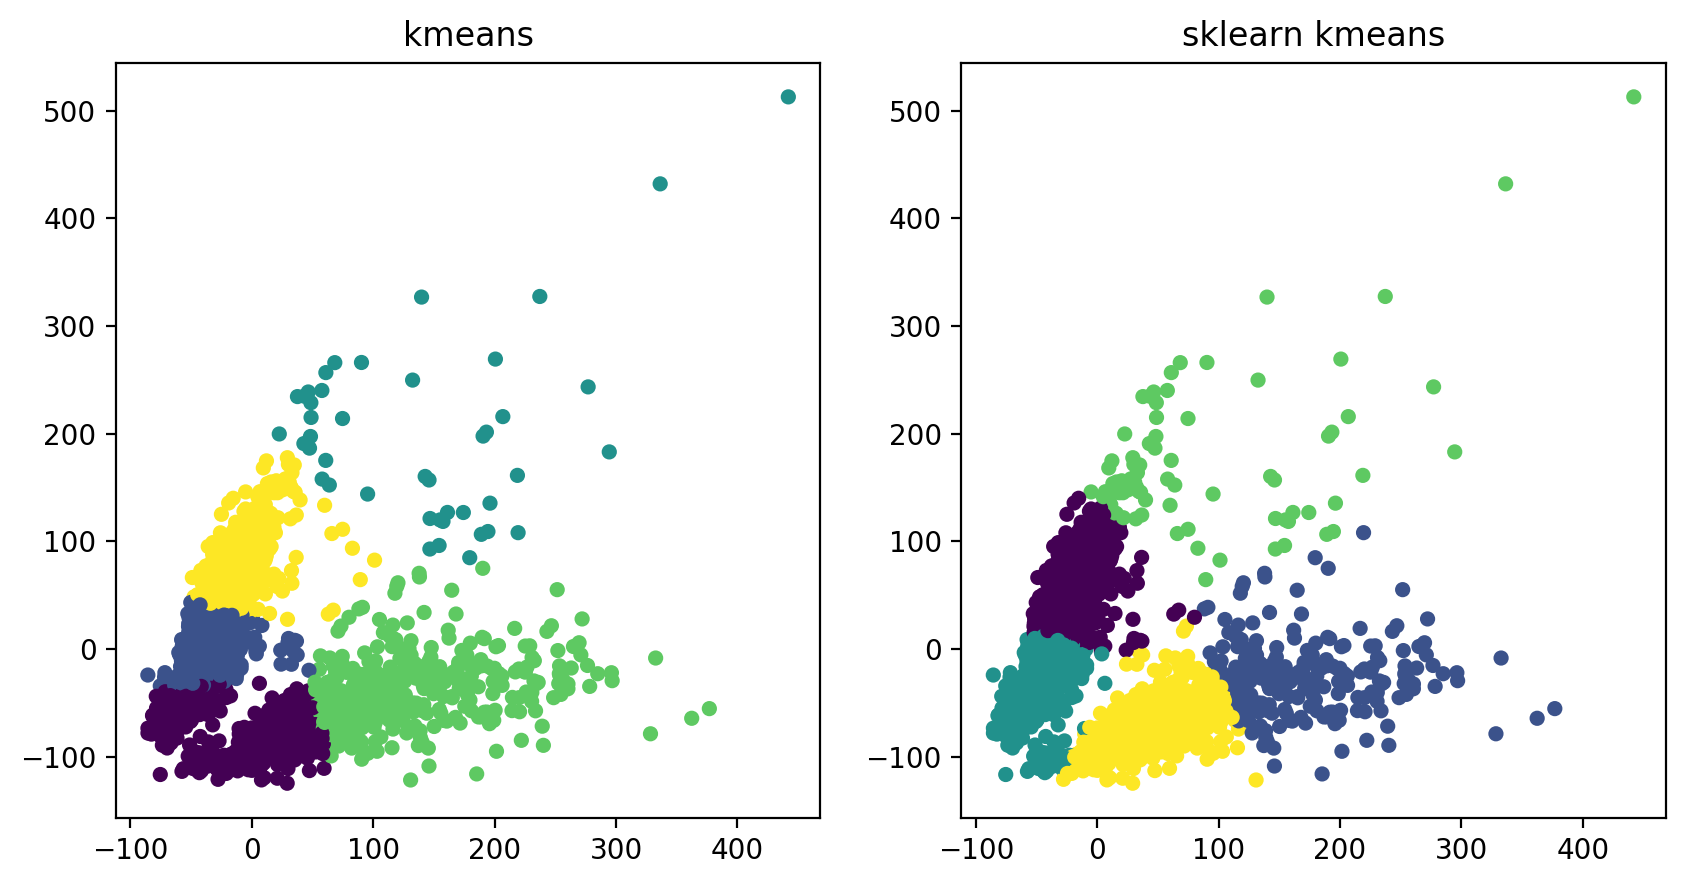

TypeError: 'str' object is not callable

In [24]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), formatter={'float_kind':lambda x: "%.2f" % x})
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], formatter={'float_kind':lambda x: "%.2f" % x}, separator = '  ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], formatter={'float_kind': "%.2f"}, separator = '  ')
print("centroids: \n" + ' ' + b_str[1:-1])


In [25]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(distances, precision=2, separator=' ')
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


20 iterations were performed


AttributeError: 'list' object has no attribute 'size'

Empty cluster! Correcting centroids.
21 iterations were performed
Distances of clusters as compared to last generation: 
[0.08 0.08 0.   0.   0.  ]

kmeans:
runtime: 0:00:02.612625
centroids: 
 [-45.51 -28.26]
 [-20.06  49.41]
 [ 42.84 -72.53]
 [ 94.79 177.74]
 [167.11 -28.12]

sklearn kmeans:
runtime: 0:00:00.119999
centroids: 
 [-45.72 -33.25]
 [-21.43  46.13]
 [ 52.15 -68.04]
 [ 85.97 173.41]
 [174.54 -25.32]


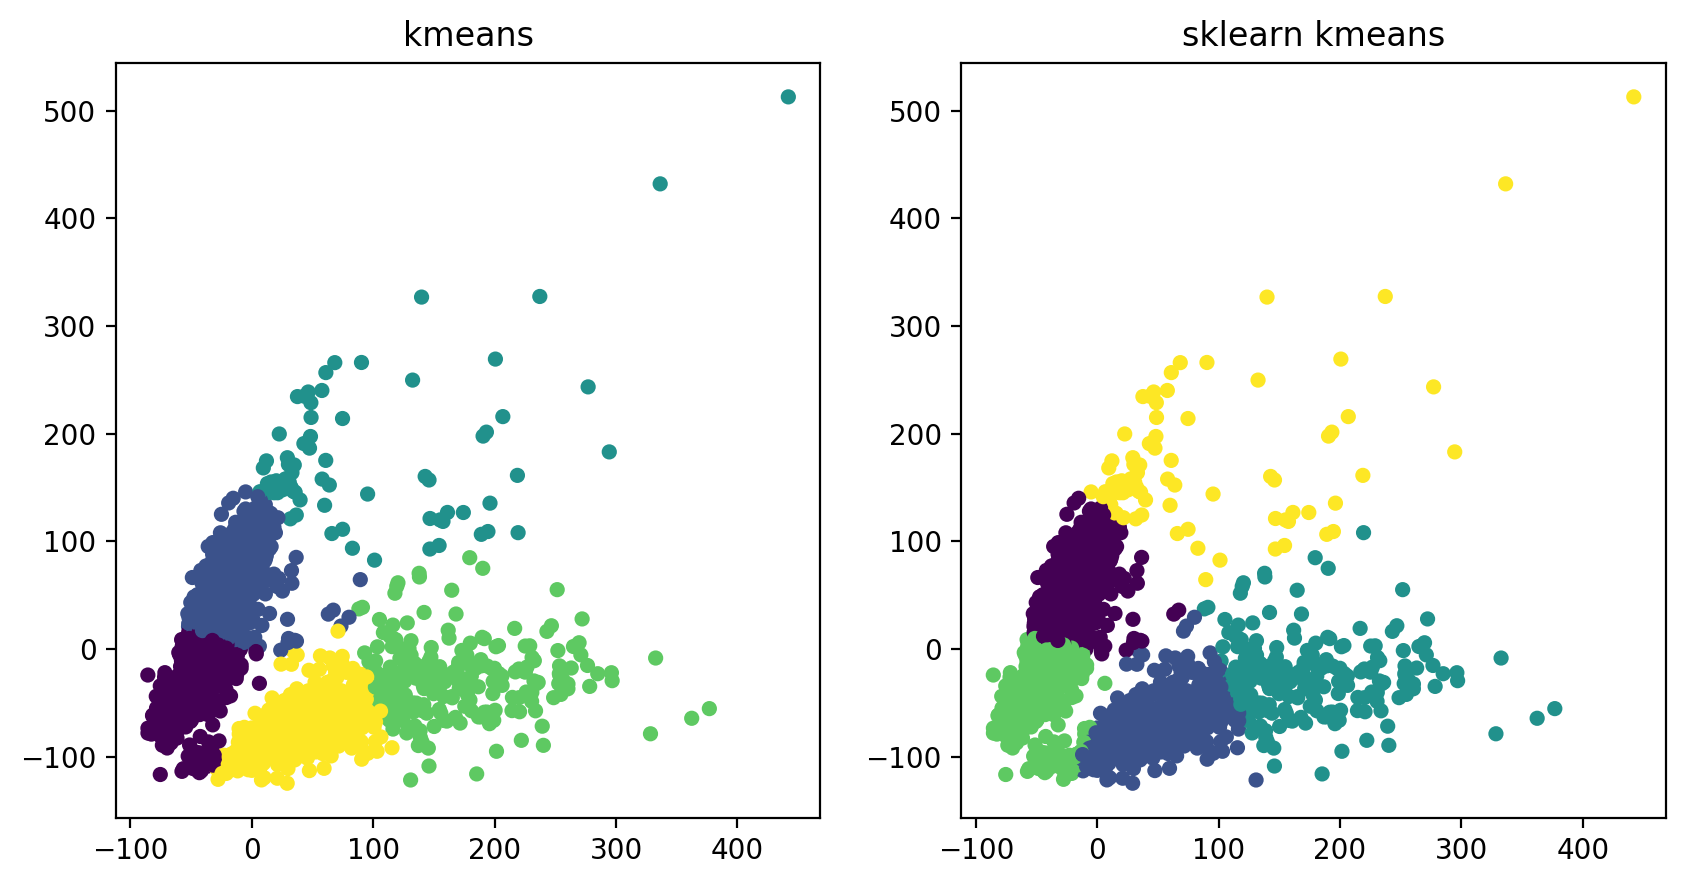

In [26]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), precision=2, separator=' ')
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


In [27]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), precision=2, separator=' ', suppress = False)
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


25 iterations were performed


TypeError: array2string() got unexpected keyword argument 'suppress'

33 iterations were performed
Distances of clusters as compared to last generation: 
[0.   0.   0.08 0.08 0.  ]

kmeans:
runtime: 0:00:03.956581
centroids: 
 [-45.48 -28.22]
 [-20.07  49.45]
 [ 42.84 -72.53]
 [ 94.79 177.74]
 [167.11 -28.12]

sklearn kmeans:
runtime: 0:00:00.079997
centroids: 
 [-45.7  -33.17]
 [-21.4   46.2 ]
 [ 52.15 -68.04]
 [ 85.97 173.41]
 [174.54 -25.32]


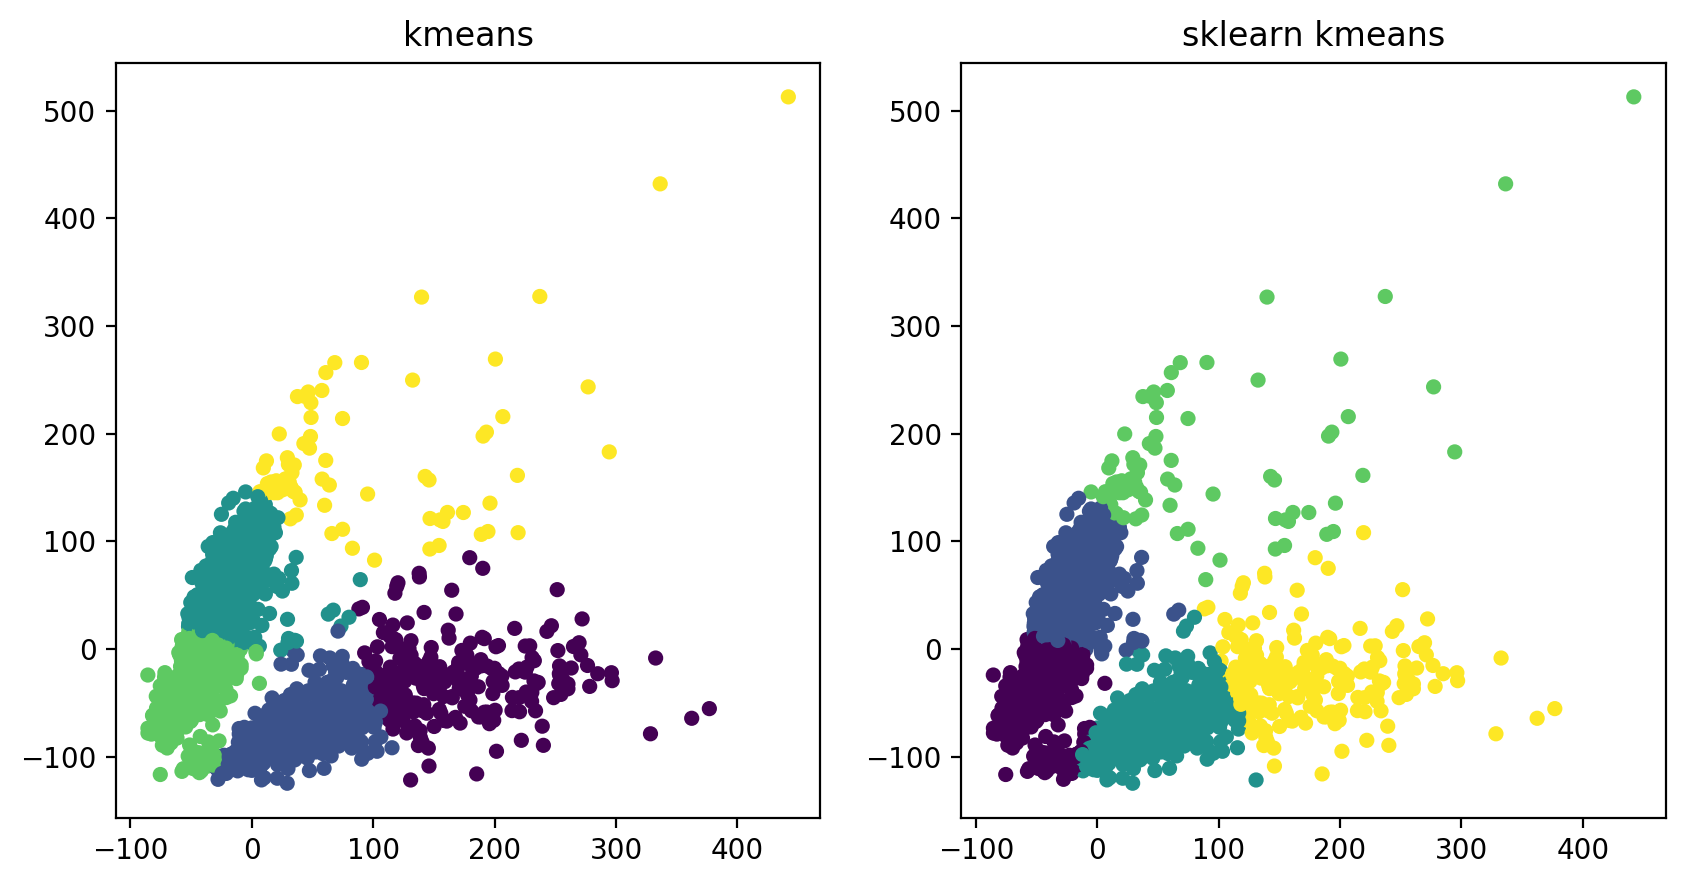

In [28]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), precision=2, separator=' ')
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.
22 iterations were performed
Distances of clusters as compared to last generation: 
[0.   0.   0.   0.08 0.08]

kmeans:
runtime: 0:00:03.308792
centroids: 
 [-45.51 -28.26]
 [-20.06  49.41]
 [ 42.84 -72.53]
 [ 94.79 177.74]
 [167.11 -28.12]

sklearn kmeans:
runtime: 0:00:00.098987
centroids: 
 [-45.72 -33.25]
 [-21.43  46.13]
 [ 52.15 -68.04]
 [ 85.97 173.41]
 [174.54 -25.32]


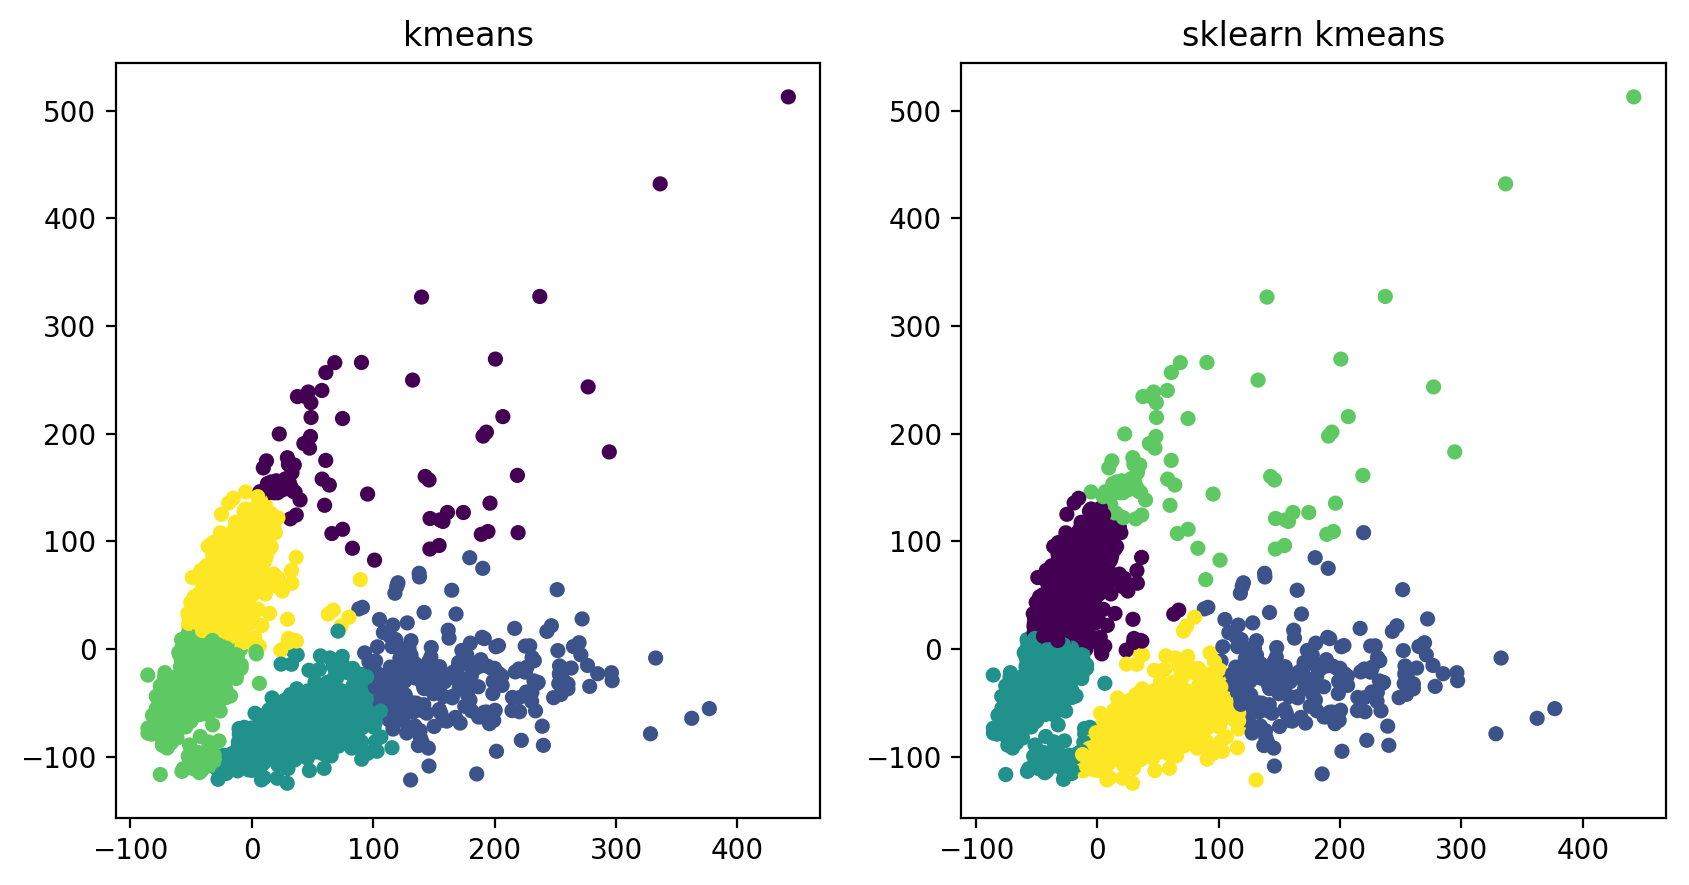

In [29]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), precision=2)
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1
    improv()

# kmeans algorythm with threshold       
def tkmeans (k2):
    global k 
    k = k2
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    new_centroids()
    assign_centroids()
    thresh(0.1) # Set threshold
    improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
# kmeans(5, 10)
tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.
Distances of clusters as compared to last generation: 
[4.01 2.1  3.85 4.23 1.16]

kmeans:
runtime: 0:00:01.685197
centroids: 
 [-43.35 -26.53]
 [-17.74  56.1 ]
 [ 56.28 -66.07]
 [130.36 198.16]
 [181.57 -24.61]

sklearn kmeans:
runtime: 0:00:00.080057
centroids: 
 [-45.89 -31.  ]
 [-21.12  46.99]
 [ 46.53 -70.99]
 [ 85.97 173.41]
 [170.06 -26.32]


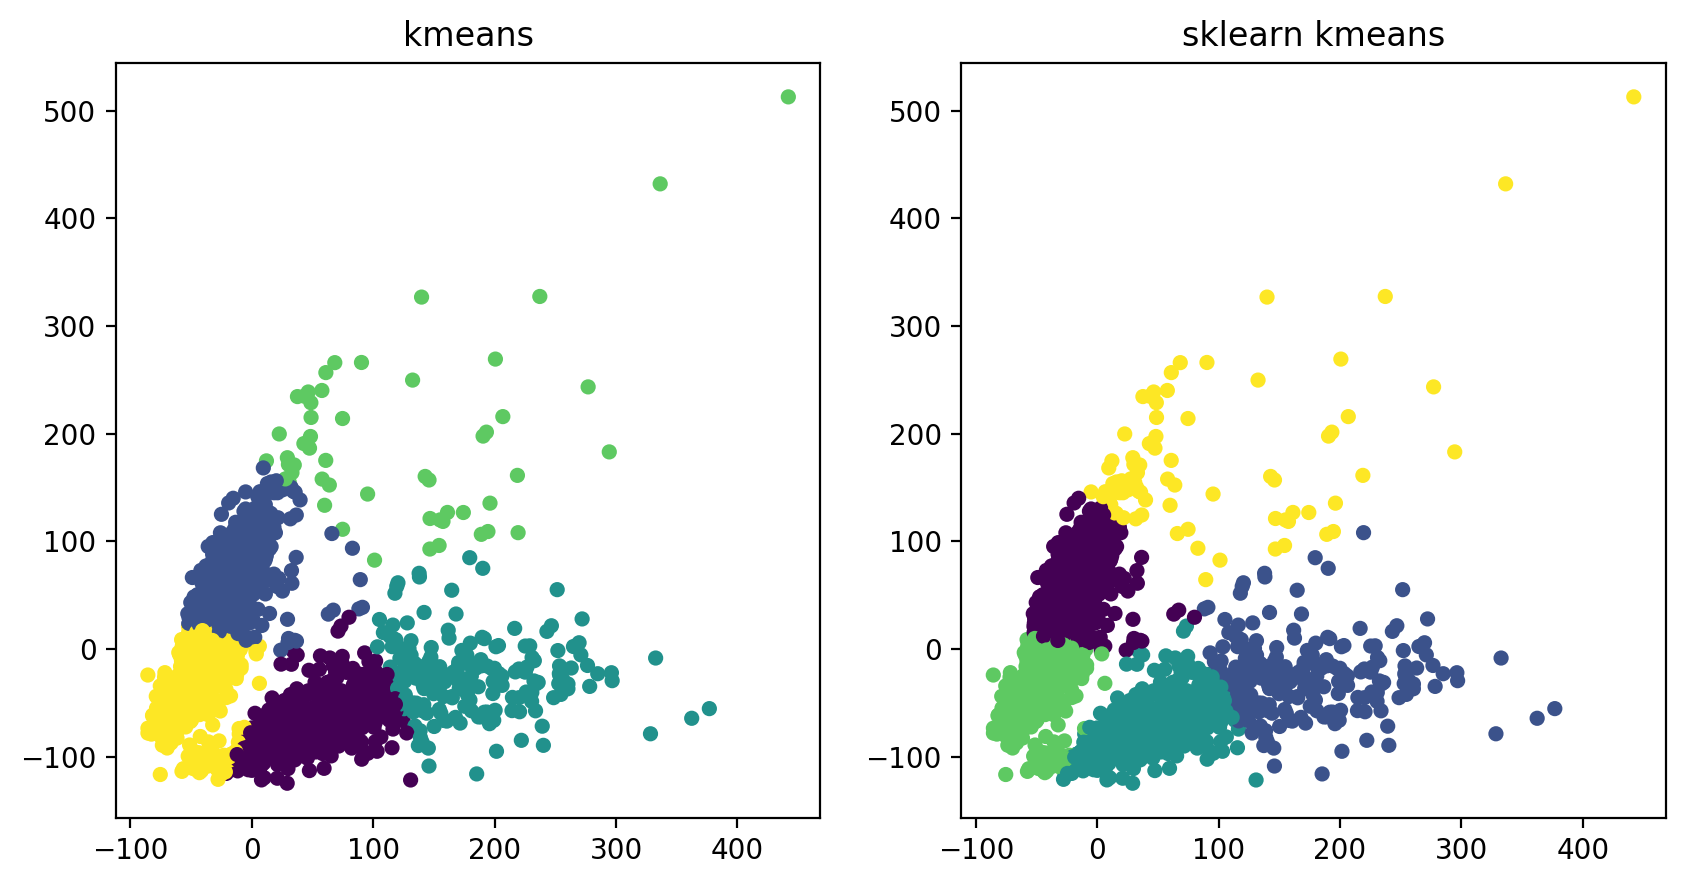

In [30]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), precision=2)
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations, t):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    if t == None:
        while i < n_iterations:
            new_centroids()
            assign_centroids()
            i += 1
    else:
        new_centroids()
        assign_centroids()
        thresh(t)
    improv()

# kmeans algorythm with threshold       
# def tkmeans (k2):
#     global k 
#     k = k2
#     random_start_centroids("randnum")
#     assign_centroids()
#     empty_check()
#     new_centroids()
#     assign_centroids()
#     thresh(0.1) # Set threshold
#     improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10, None)
# tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


20 iterations were performed
Distances of clusters as compared to last generation: 
[0.04 0.   0.04 0.   0.  ]

kmeans:
runtime: 0:00:02.196309
centroids: 
 [-45.36 -31.6 ]
 [-20.87  47.72]
 [ 51.3  -68.5 ]
 [ 89.79 177.08]
 [174.24 -25.35]

sklearn kmeans:
runtime: 0:00:00.087974
centroids: 
 [-45.72 -33.25]
 [-21.43  46.13]
 [ 52.15 -68.04]
 [ 85.97 173.41]
 [174.54 -25.32]


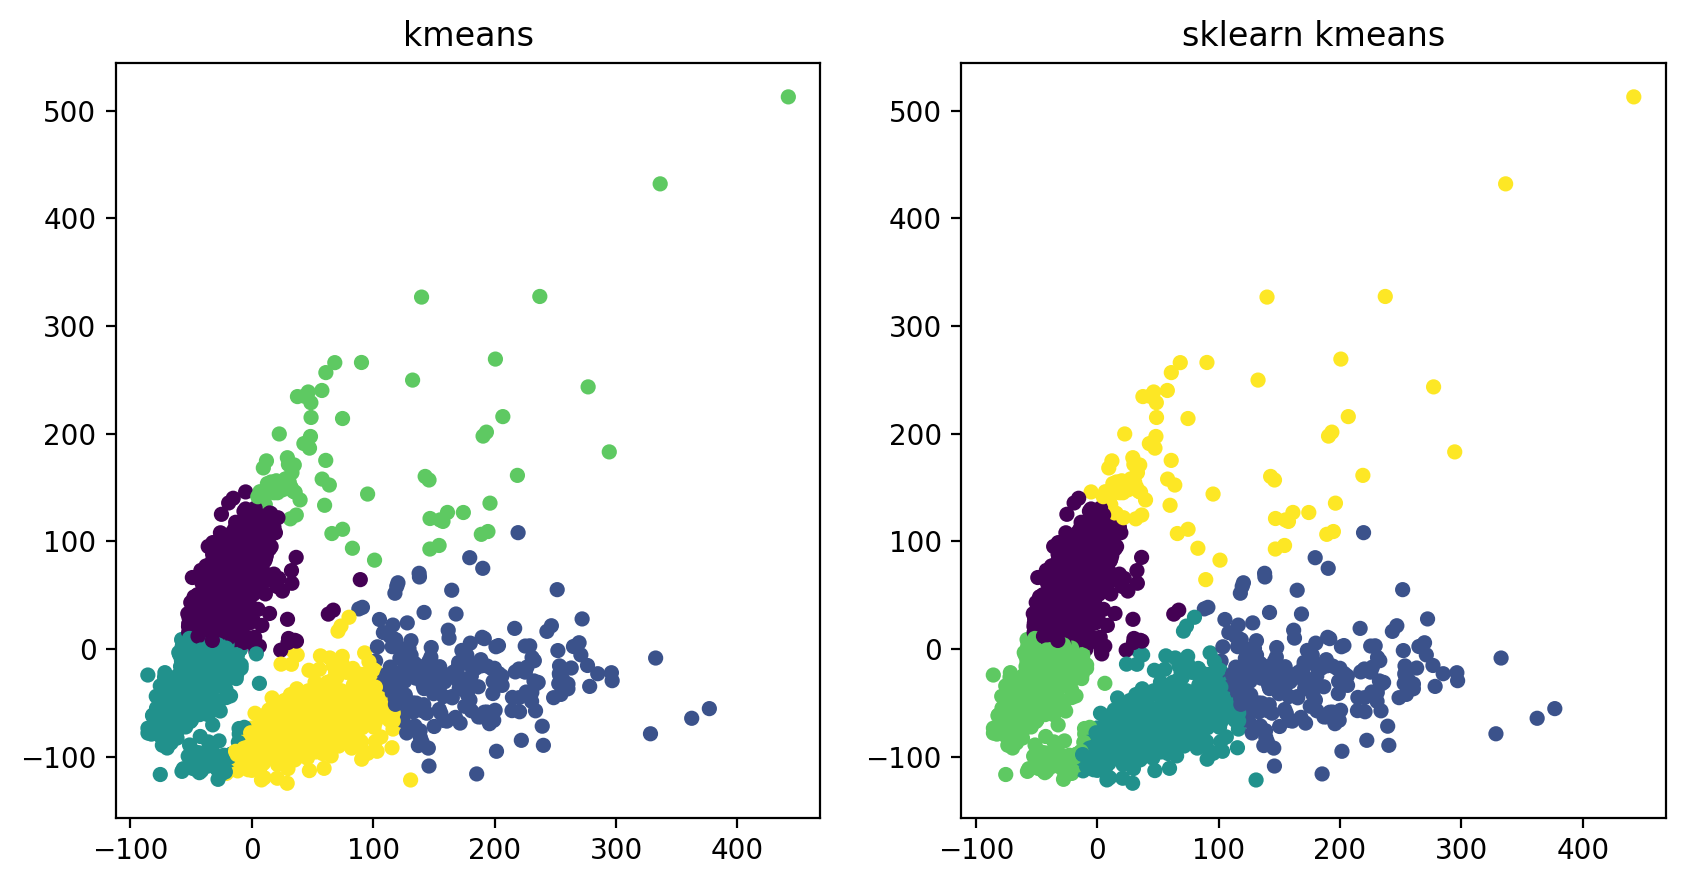

In [31]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), precision=2)
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations, t):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    if t == None:
        while i < n_iterations:
            new_centroids()
            assign_centroids()
            i += 1
    else:
        new_centroids()
        assign_centroids()
        thresh(t)
    improv()

# kmeans algorythm with threshold       
# def tkmeans (k2):
#     global k 
#     k = k2
#     random_start_centroids("randnum")
#     assign_centroids()
#     empty_check()
#     new_centroids()
#     assign_centroids()
#     thresh(0.1) # Set threshold
#     improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10, 0.1)
# tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.
24 iterations were performed
Distances of clusters as compared to last generation: 
[0.   0.   0.   0.08 0.08]

kmeans:
runtime: 0:00:03.891454
centroids: 
 [-45.51 -28.26]
 [-20.06  49.41]
 [ 42.84 -72.53]
 [ 94.79 177.74]
 [167.11 -28.12]

sklearn kmeans:
runtime: 0:00:00.086800
centroids: 
 [-45.74 -30.3 ]
 [-20.85  47.7 ]
 [ 46.34 -71.08]
 [ 87.74 174.59]
 [170.06 -26.32]


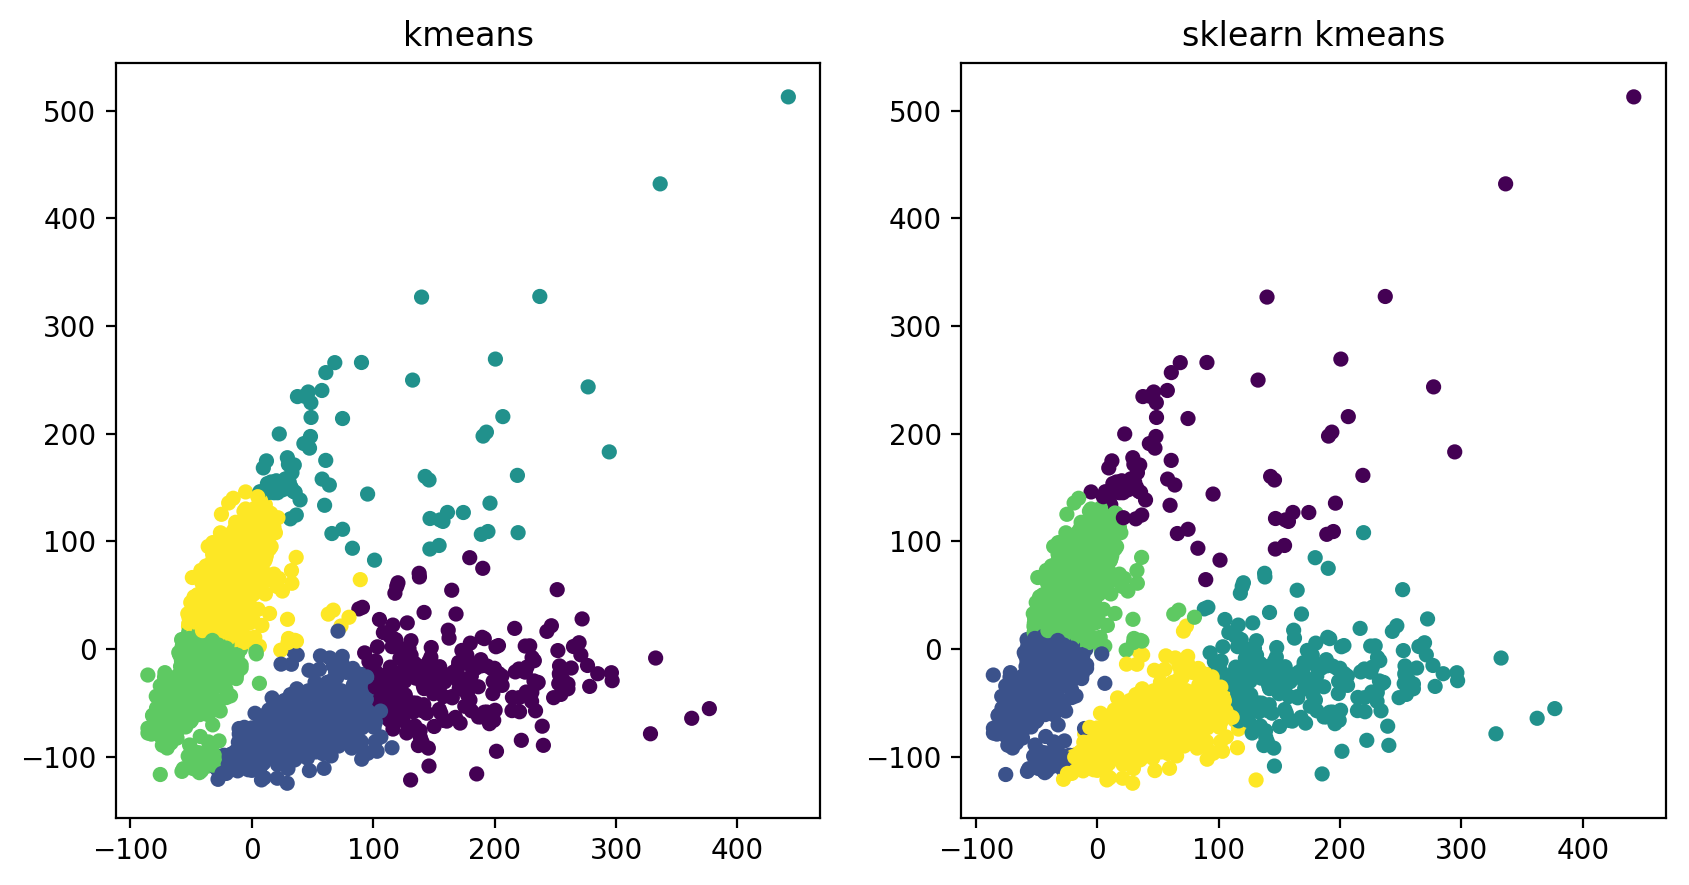

In [32]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), precision=2)
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations, t):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    if t == None:
        while i < n_iterations:
            new_centroids()
            assign_centroids()
            i += 1
    else:
        new_centroids()
        assign_centroids()
        thresh(t)
    improv()

# kmeans algorythm with threshold       
# def tkmeans (k2):
#     global k 
#     k = k2
#     random_start_centroids("randnum")
#     assign_centroids()
#     empty_check()
#     new_centroids()
#     assign_centroids()
#     thresh(0.1) # Set threshold
#     improv()


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, None, 0.1)
# tkmeans(5)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


26 iterations were performed
Distances of clusters as compared to last generation: 
[0. 0. 0. 0. 0.]

kmeans:
runtime: 0:00:02.967858
centroids: 
 [-45.62 -29.61]
 [-20.43  48.67]
 [ 46.01 -71.19]
 [ 94.79 177.74]
 [169.85 -26.89]

sklearn kmeans:
runtime: 0:00:00.103998
centroids: 
 [-45.72 -33.25]
 [-21.43  46.13]
 [ 52.15 -68.04]
 [ 85.97 173.41]
 [174.54 -25.32]


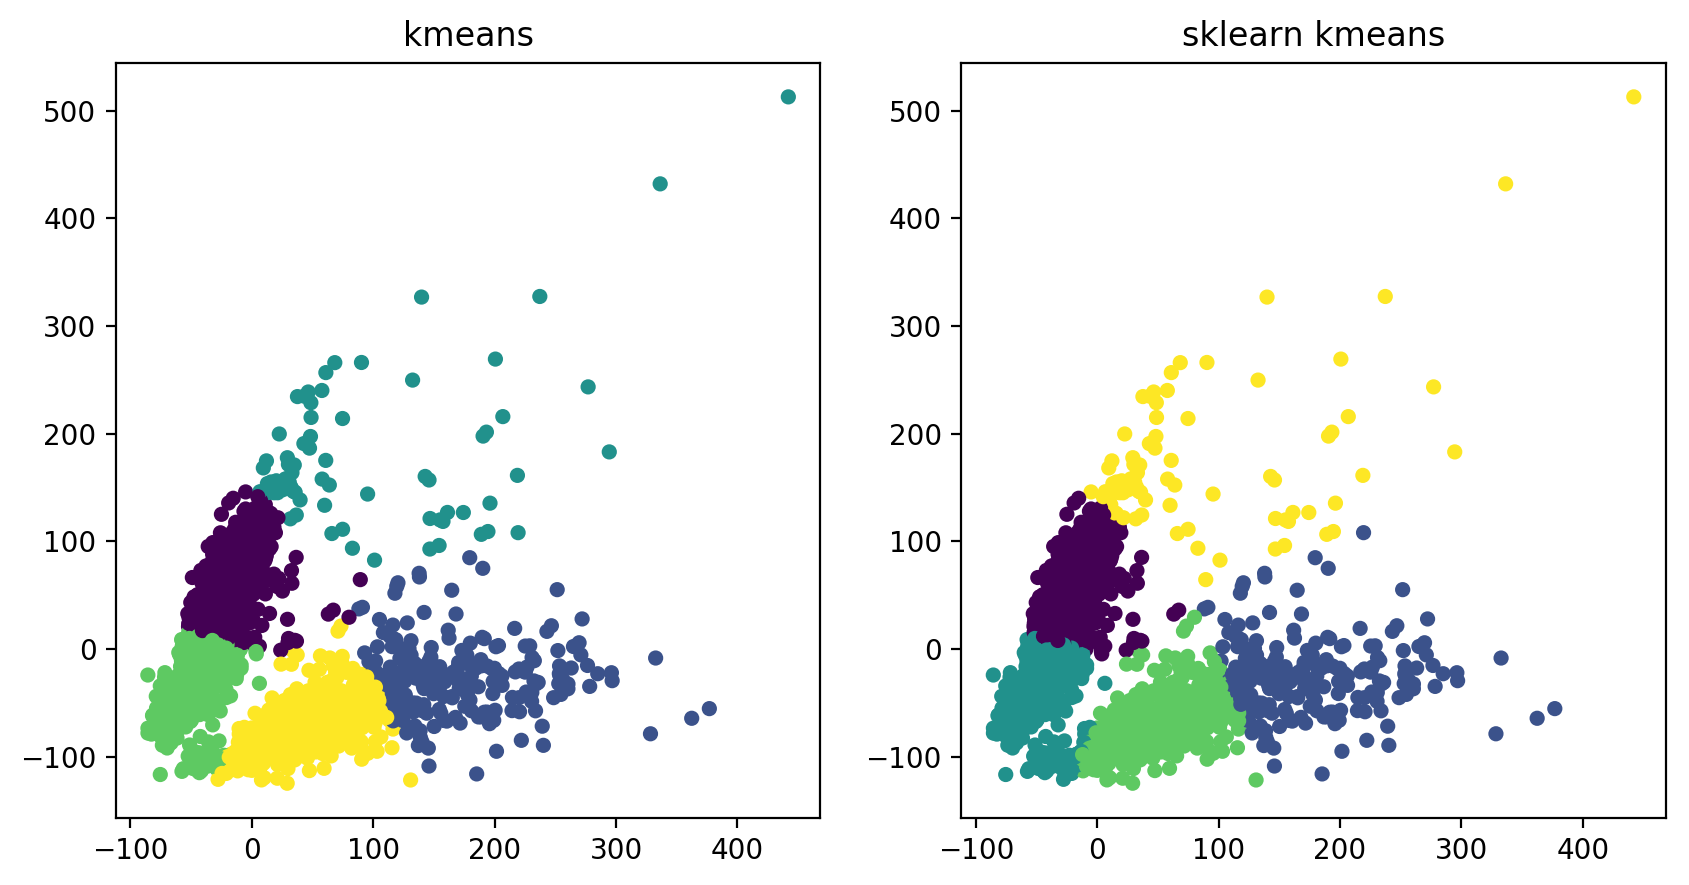

In [33]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), precision=2)
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations, t):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    if t == None:
        while i < n_iterations:
            new_centroids()
            assign_centroids()
            i += 1
    else:
        new_centroids()
        assign_centroids()
        thresh(t)
    improv()

# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()

# Clusters, Iterations (egal wenn t), Threshhold [float oder None]
kmeans(5, 10, 0.1)

print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])


49 iterations were performed
Distances of clusters as compared to last generation: 
[0.   0.06 0.   0.06 0.07]

kmeans:
runtime: 0:00:07.213770
centroids: 
 [-35.3    3.05]
 [-25.86 -68.04]
 [-11.42  71.75]
 [133.88 -38.63]
 [142.03 199.53]

sklearn kmeans:
runtime: 0:00:00.098210
centroids: 
 [-45.72 -33.25]
 [-21.43  46.13]
 [ 52.15 -68.04]
 [ 85.97 173.41]
 [174.54 -25.32]


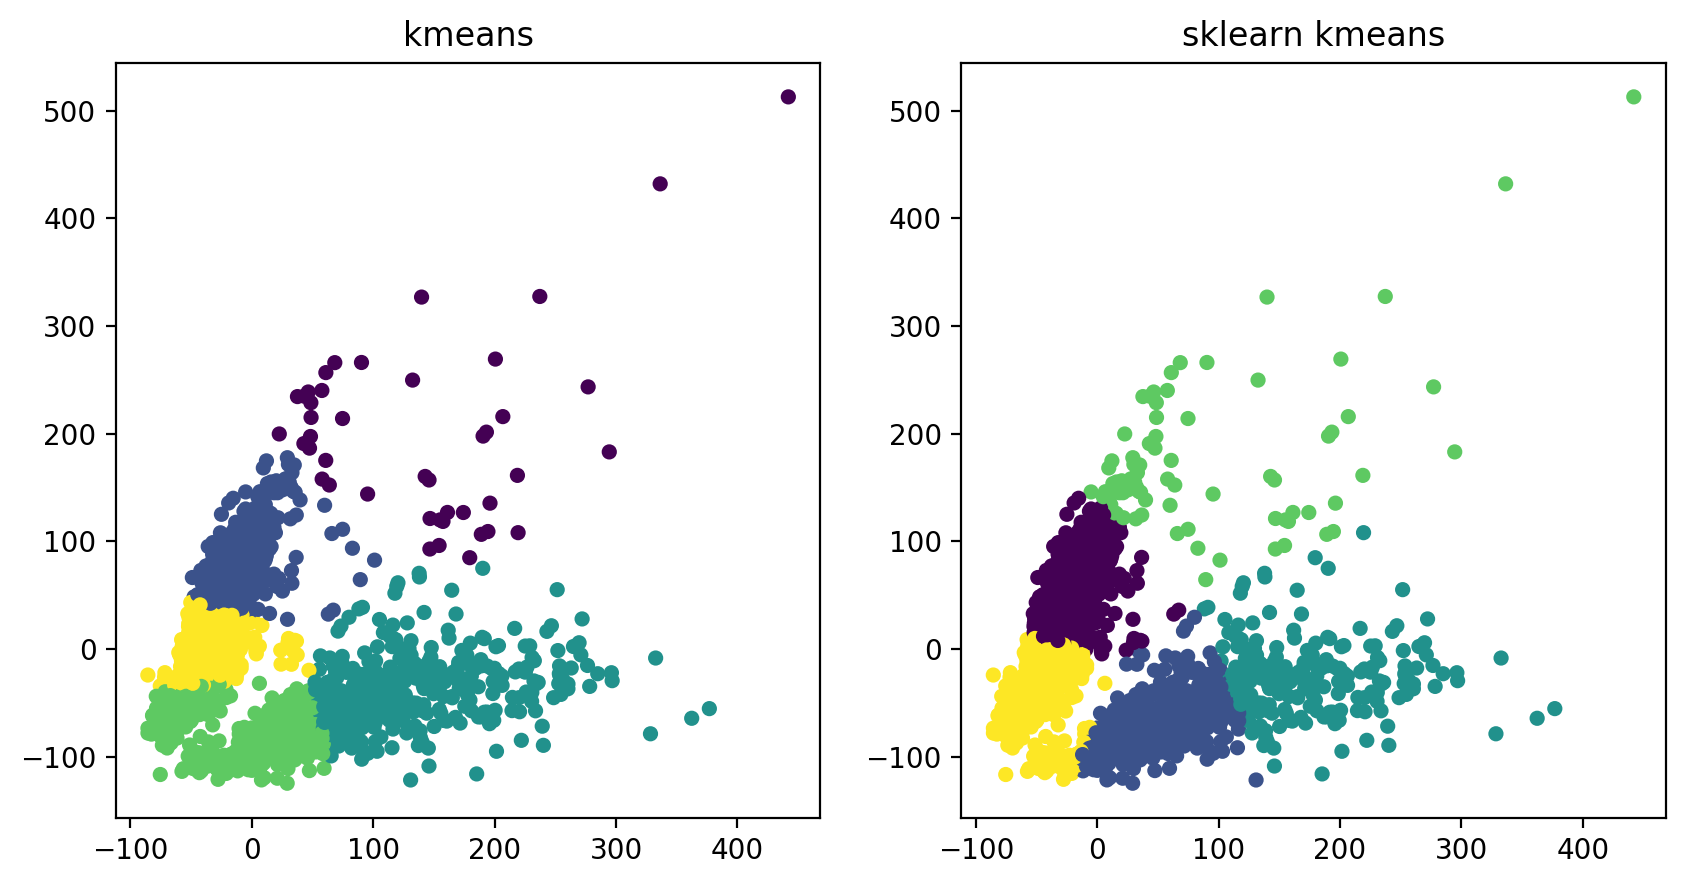

In [1]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), precision=2)
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(k1, n_iterations, t):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    if t == None:
        while i < n_iterations:
            new_centroids()
            assign_centroids()
            i += 1
    else:
        new_centroids()
        assign_centroids()
        thresh(t)
    improv()

# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()

# Clusters, Iterations (egal wenn t), Threshhold [float oder None]
kmeans(5, 10, 0.1)

print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])
